<a href="https://colab.research.google.com/github/eg1511/Arabic-NER-location-mapping/blob/main/Arabic_NER_location_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prep Work**

## *PyTorch & GPU check*

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct  7 06:06:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## *Install Packages:*

In [ ]:
!pip install camel-tools

In [ ]:
!pip install gspread

In [ ]:
!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install geopy

In [ ]:
!pip install country_converter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.7 MB/s eta 0:00:00


Bugs:

In [ ]:
#!pip install --upgrade --force-reinstall gspread

---

## *Credentials:*

- Google Sheets:

In [ ]:
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

- Hunging Face:

In [ ]:
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

## *Data Prep:*

### *Files:*

- Upload the 2 GoogleSheets files:

-- Open Articles Frontpage and upload data as df_articles:

In [ ]:
# Replace 'YOUR_GOOGLE_SHEET_URL' with the actual URL of your Google Sheet
spreadsheet = gc.open_by_url('xxxx') #<-- INSERT YOUR GOOGLESHEETS

# Replace 'Sheet1' with the name of the worksheet you want to load
worksheet = spreadsheet.worksheet('Sheet1')

# Get all the values from the worksheet
data = worksheet.get_all_values()

# Convert the data to a pandas DataFrame
df_articles = pd.DataFrame(data[1:], columns=data[0])

# Convert specified columns to numeric, coercing errors, then fill NaN with 0 and convert to integer
for col in ['Articleid', 'Issue number', 'Page number', 'Referal Page']:
    df_articles[col] = pd.to_numeric(df_articles[col], errors='coerce').fillna(0).astype(int)

# Convert date to date type
df_articles['date'] = pd.to_datetime(df_articles['date'], errors='coerce')


# Display the first few rows of the new DataFrame
display(df_articles.head())

Articleid  Issue number  Page number       date      Type  \
0          1             1            1 2015-10-16  Headline   
1          2             2            1 2015-10-23  Headline   
2          3             3            1 2005-10-30  Headline   
3          4             4            1 2015-11-06  Headline   
4          5             5            1 2015-11-14  Headline   

                                               Title  \
0   خسائر كبيرة يتكبدها الرافضة في أطراف بيجي و ش...   
1   ‫إنزال أمريكي فاشل قرب الحويجة وصد محاولات ال...   
2   ‫مدينة سامراء في مرمى جيش الخلافة بعد عملية ا...   
3   ‫ردا على قصفهم المسلمين في الشام ‪ ...‬إسقاط ...   
4  300 قتيل وجريح في عمليات استشهادية تستهدف معقل...   

                                                Body  Referal Page  
0  عمليتان استشهاديتان تستهدفان تجمعات الروافض با...             3  
1  تفاصيل عملية الإنزال الجوي‪ ،‬التي نفذتها القو...             2  
2   ‫في الوقت الذي يقوم فيه الجيش الصفوي بأكبر حم...             2  
3  أعلنت وزارة الدفاع الروسية في بداية شهر ذي الح...             3  
4  في إطار عمليات جنود الخلافة التي تستهدف الأحزا...             3

In [ ]:
display(df_articles.dtypes)

Articleid                int64
Issue number             int64
Page number              int64
date            datetime64[ns]
Type                    object
Title                   object
Body                    object
Referal Page             int64
dtype: object

-- Open Articles Frontpage and upload data as df_dir:

In [ ]:
# Replace 'YOUR_GOOGLE_SHEET_URL' with the actual URL of your Google Sheet
spreadsheet2 = gc.open_by_url('xxxxx') #<-- INSERT YOUR GOOGLESHEETS

# Replace 'Sheet2' with the name of the worksheet you want to load
worksheet = spreadsheet2.worksheet('Sheet2')

# Get all the values from the worksheet
directory = worksheet.get_all_values()

# Convert the data to a pandas DataFrame
df_dir = pd.DataFrame(directory[1:], columns=directory[0])

# Display the first few rows of the new DataFrame
display(df_dir.head())

city      region      country
0      بدخشان  Badakhshan  Afghanistan
1  badakhshan  Badakhshan  Afghanistan
2         جرم  Badakhshan  Afghanistan
3        jurm  Badakhshan  Afghanistan
4      بدخشان  Badakhshan  Afghanistan

# **Data Transform**

### *Libraries*

In [ ]:
import pandas as pd
import numpy as np

### *Soft Transform:*


Merging Title and Body together to get the full text:

In [ ]:
df = df_articles.copy()
df['merge_text'] = np.where(df['Title'].isnull(), df['Body'], np.where(df['Body'].isnull(), df['Title'], df['Title'] + ' ' + df['Body']))

df

Articleid  Issue number  Page number       date      Type  \
0             1             1            1 2015-10-16  Headline   
1             2             2            1 2015-10-23  Headline   
2             3             3            1 2005-10-30  Headline   
3             4             4            1 2015-11-06  Headline   
4             5             5            1 2015-11-14  Headline   
...         ...           ...          ...        ...       ...   
3271       3272           269            1 2021-01-14   Picture   
3272       3273           270            1 2021-01-21   Picture   
3273       3274           271            1 2021-01-28   Picture   
3274       3275           272            1 2021-02-04   Picture   
3275       3276           273            1 2021-02-11   Picture   

                                                  Title  \
0      خسائر كبيرة يتكبدها الرافضة في أطراف بيجي و ش...   
1      ‫إنزال أمريكي فاشل قرب الحويجة وصد محاولات ال...   
2      ‫مدينة سامراء في مرمى جيش الخلافة بعد عملية ا...   
3      ‫ردا على قصفهم المسلمين في الشام ‪ ...‬إسقاط ...   
4     300 قتيل وجريح في عمليات استشهادية تستهدف معقل...   
...                                                 ...   
3271                                                      
3272                                                      
3273                                                      
3274                                                      
3275                                                      

                                                   Body  Referal Page  \
0     عمليتان استشهاديتان تستهدفان تجمعات الروافض با...             3   
1     تفاصيل عملية الإنزال الجوي‪ ،‬التي نفذتها القو...             2   
2      ‫في الوقت الذي يقوم فيه الجيش الصفوي بأكبر حم...             2   
3     أعلنت وزارة الدفاع الروسية في بداية شهر ذي الح...             3   
4     في إطار عمليات جنود الخلافة التي تستهدف الأحزا...             3   
...                                                 ...           ...   
3271                                                                0   
3272                                                                0   
3273                                                                0   
3274                                                                0   
3275                                                                0   

                                             merge_text  
0      خسائر كبيرة يتكبدها الرافضة في أطراف بيجي و ش...  
1      ‫إنزال أمريكي فاشل قرب الحويجة وصد محاولات ال...  
2      ‫مدينة سامراء في مرمى جيش الخلافة بعد عملية ا...  
3      ‫ردا على قصفهم المسلمين في الشام ‪ ...‬إسقاط ...  
4     300 قتيل وجريح في عمليات استشهادية تستهدف معقل...  
...                                                 ...  
3271                                                     
3272                                                     
3273                                                     
3274                                                     
3275                                                     

[3276 rows x 9 columns]

### *Hard Transform*

#### *Adding CAMEL & Arabert:*

Reference for:
CAMeL - https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-msa-ner

##### Libraries:

In [ ]:
#CAMeL - https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-msa-ner

from camel_tools.ner import NERecognizer
from camel_tools.tokenizers.word import simple_word_tokenize

##### Function - Add Named Entity Recognition for Location only

In [ ]:
def extract_location_entities(row):
    if isinstance(row['merge_text'], float):
        return None
    else:
        ner = NERecognizer('CAMeL-Lab/bert-base-arabic-camelbert-msa-ner')
        tokens = simple_word_tokenize(row['merge_text'])
        labels = ner.predict_sentence(tokens)
        location_entities = [token for token, label in zip(tokens, labels) if label in ['B-LOC', 'I-LOC']]
        return location_entities

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Transform Data to add NER location only in Location_Entities column

In [ ]:
df['Location_Entities'] = df.apply(extract_location_entities, axis=1)

config.json:   0%|          | 0.00/980 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on a

In [ ]:
display(df.head())

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/my_dataframe.csv', index=False)

#### *Adding Transformation from GTD Transform sheet:*

##### Defining the word to city dictionary:

In [ ]:
# Create a dictionary mapping city to a tuple of (region, country)
# This assumes cities are unique keys. If cities are not unique, the last entry for a city will overwrite previous ones.
mydict_city = dict(zip(df_dir['city'], zip(df_dir['region'], df_dir['country'])))

##### Defining the function to get locations from merge_text

In [ ]:
def check_text_presence(merge_text, city_texts):
    """
    Checks if any word from the city_texts list is present in the merge_text.
    """
    if not isinstance(merge_text, str):
        return False
    for text in city_texts:
        if isinstance(text, str) and text in merge_text:
            return True
    return False

# Get the list of texts from df_city['text']
city_texts = df_dir['city'].tolist()

# Apply the function to create a new column indicating presence
df['text_from_city_present'] = df['merge_text'].apply(lambda x: check_text_presence(x, city_texts))

display(df[['merge_text', 'text_from_city_present']].head())

In [ ]:
def update_location_internalDB(row):
    """
    Updates Location_internalDB_new with the city name from df_dir if text_from_city_present is True.
    """
    if row['text_from_city_present']:
        merge_text = row['merge_text']
        # Find the matching text in df_dir and get the corresponding city
        for index, city_row in df_dir.iterrows():
            if isinstance(merge_text, str) and isinstance(city_row['city'], str) and city_row['city'] in merge_text:
                return [city_row['city']] # Return as a list to match the column's expected format
    return None # Return None if no match or text_from_city_present is False

##### Applying the function to get locations from *merge_text*

In [ ]:
df['Location_internalDB'] = df.apply(update_location_internalDB, axis=1)
display(df[['merge_text', 'text_from_city_present', 'Location_internalDB']].head())

merge_text  text_from_city_present  \
0   خسائر كبيرة يتكبدها الرافضة في أطراف بيجي و ش...                    True   
1   ‫إنزال أمريكي فاشل قرب الحويجة وصد محاولات ال...                    True   
2   ‫مدينة سامراء في مرمى جيش الخلافة بعد عملية ا...                    True   
3   ‫ردا على قصفهم المسلمين في الشام ‪ ...‬إسقاط ...                    True   
4  300 قتيل وجريح في عمليات استشهادية تستهدف معقل...                    True   

  Location_internalDB  
0              [بيجي]  
1           [الحويجة]  
2            [سامراء]  
3              [سينا]  
4               [الب]

##### Applying a modified function to get locations from *Location_Entities*

In [ ]:
def check_text_presence_on_list(Location_Entities, city_texts):
    """
    Checks if any string in Location_Entities contains any string in city_texts, or vice versa, based on containment.
    """
    if not isinstance(Location_Entities, list) or not isinstance(city_texts, list):
        return False # Return False if inputs are not lists

    for entity in Location_Entities:
        if not isinstance(entity, str):
            continue # Skip non-string entities

        for city_text in city_texts:
            if not isinstance(city_text, str):
                continue # Skip non-string city texts

            # Case-insensitive containment check in both directions
            if city_text.lower() in entity.lower() or entity.lower() in city_text.lower():
                return True # Return True as soon as a containment is found

    return False # Return False if no containment is found after checking all pairs

In [ ]:
# Get the list of texts from df_dir['city']
city_texts = df_dir['city'].tolist()

# Apply the function to create a new column indicating presence
df['LE_from_city_present'] = df['Location_Entities'].apply(lambda x: check_text_presence_on_list(x, city_texts))

display(df[['Location_Entities', 'LE_from_city_present']].head())

In [ ]:
def update_location_LE_internalDB(row):
    """
    Updates LE_from_city_present_internalDB with a list of matching strings from Location_Entities
    that are present in df_dir['city'], based on containment.
    """
    location_entities = row['Location_Entities']
    matching_entities = []
    city_list_lower = [city.lower() for city in df_dir['city'].tolist() if isinstance(city, str)] # Create a lowercased list of cities for efficient checking

    if isinstance(location_entities, list):
        for entity in location_entities:
            if isinstance(entity, str):
                # Check if the entity (or part of it) is contained within any city in df_dir['city']
                # Or if any city in df_dir['city'] is contained within the entity (or part of it)
                if any(entity.lower() in city.lower() or city.lower() in entity.lower() for city in city_list_lower):
                     if entity not in matching_entities: # Avoid duplicates
                        matching_entities.append(entity)

    return matching_entities if matching_entities else None

In [ ]:
df['LE_from_city_present_internalDB'] = df.apply(update_location_LE_internalDB, axis=1)
display(df[['Location_Entities', 'LE_from_city_present', 'LE_from_city_present_internalDB']].head())

In [ ]:
def combine_and_deduplicate_locations(row):
    """
    Combines the lists in 'Location_internalDB' and 'LE_from_city_present_internalDB',
    removes duplicates, and returns a single list. Handles None values.
    """
    list1 = row['Location_internalDB']
    list2 = row['LE_from_city_present_internalDB']

    combined_list = []
    if isinstance(list1, list):
        combined_list.extend(list1)
    elif isinstance(list1, str): # Handle cases where it might be a single string
         combined_list.append(list1)


    if isinstance(list2, list):
        combined_list.extend(list2)
    elif isinstance(list2, str): # Handle cases where it might be a single string
        combined_list.append(list2)


    # Remove duplicates while preserving order (optional, but often desired)
    # Using a set to remove duplicates efficiently
    seen = set()
    deduplicated_list = []
    for item in combined_list:
        if item not in seen:
            seen.add(item)
            deduplicated_list.append(item)

    return deduplicated_list if deduplicated_list else None # Return None if the combined list is empty

df['Location_internalDB_all'] = df.apply(combine_and_deduplicate_locations, axis=1)

In [ ]:
df['Location_internalDB_all'] = df.apply(combine_and_deduplicate_locations, axis=1)
display(df[['Location_internalDB', 'LE_from_city_present_internalDB', 'Location_internalDB_all']].head())

Location_internalDB LE_from_city_present_internalDB  \
0              [بيجي]             [بيجي, تكريت, صلاح]   
1           [الحويجة]  [الحويجة, عجيل, كركوك, علا, س]   
2            [سامراء]                        [سامراء]   
3              [سينا]                  [الشام, سيناء]   
4               [الب]          [بيروت, برج, البراجنة]   

          Location_internalDB_all  
0             [بيجي, تكريت, صلاح]  
1  [الحويجة, عجيل, كركوك, علا, س]  
2                        [سامراء]  
3            [سينا, الشام, سيناء]  
4     [الب, بيروت, برج, البراجنة]

##### Result:

In [ ]:
df

Articleid  Issue number  Page number       date      Type  \
0             1             1            1 2015-10-16  Headline   
1             2             2            1 2015-10-23  Headline   
2             3             3            1 2005-10-30  Headline   
3             4             4            1 2015-11-06  Headline   
4             5             5            1 2015-11-14  Headline   
...         ...           ...          ...        ...       ...   
3271       3272           269            1 2021-01-14   Picture   
3272       3273           270            1 2021-01-21   Picture   
3273       3274           271            1 2021-01-28   Picture   
3274       3275           272            1 2021-02-04   Picture   
3275       3276           273            1 2021-02-11   Picture   

                                                  Title  \
0      خسائر كبيرة يتكبدها الرافضة في أطراف بيجي و ش...   
1      ‫إنزال أمريكي فاشل قرب الحويجة وصد محاولات ال...   
2      ‫مدينة سامراء في مرمى جيش الخلافة بعد عملية ا...   
3      ‫ردا على قصفهم المسلمين في الشام ‪ ...‬إسقاط ...   
4     300 قتيل وجريح في عمليات استشهادية تستهدف معقل...   
...                                                 ...   
3271                                                      
3272                                                      
3273                                                      
3274                                                      
3275                                                      

                                                   Body  Referal Page  \
0     عمليتان استشهاديتان تستهدفان تجمعات الروافض با...             3   
1     تفاصيل عملية الإنزال الجوي‪ ،‬التي نفذتها القو...             2   
2      ‫في الوقت الذي يقوم فيه الجيش الصفوي بأكبر حم...             2   
3     أعلنت وزارة الدفاع الروسية في بداية شهر ذي الح...             3   
4     في إطار عمليات جنود الخلافة التي تستهدف الأحزا...             3   
...                                                 ...           ...   
3271                                                                0   
3272                                                                0   
3273                                                                0   
3274                                                                0   
3275                                                                0   

                                             merge_text  \
0      خسائر كبيرة يتكبدها الرافضة في أطراف بيجي و ش...   
1      ‫إنزال أمريكي فاشل قرب الحويجة وصد محاولات ال...   
2      ‫مدينة سامراء في مرمى جيش الخلافة بعد عملية ا...   
3      ‫ردا على قصفهم المسلمين في الشام ‪ ...‬إسقاط ...   
4     300 قتيل وجريح في عمليات استشهادية تستهدف معقل...   
...                                                 ...   
3271                                                      
3272                                                      
3273                                                      
3274                                                      
3275                                                      

                                      Location_Entities  \
0               [بيجي, تكريت, صلاح, الدين, بيجي, تكريت]   
1     [الحويجة, علاس, عجيل, الحويجة, كركوك, علا, س, ...   
2                              [سامراء, سامراء, سامراء]   
3            [الشام, سيناء, الشام, الشام, سيناء, الشام]   
4                         [بيروت, بيروت, برج, البراجنة]   
...                                                 ...   
3271                                                 []   
3272                                                 []   
3273                                                 []   
3274                                                 []   
3275                                                 []   

      text_from_city_present Location_internalDB  LE_from_city_present  \
0                       True              [بيجي]                  True   
1                       True           [الحويجة] 

#### *Adding Translation:*

##### Deep Translator:

Reference for: Deep Translator - https://pypi.org/project/deep-translator/

Documentation: https://deep-translator.readthedocs.io/

In [ ]:
from deep_translator import (GoogleTranslator, PonsTranslator,
                             LingueeTranslator,
                             MyMemoryTranslator,
                             YandexTranslator,
                             DeeplTranslator,
                             QcriTranslator,
                             single_detection,
                             batch_detection)

import time # Import the time module

In [ ]:
translator = GoogleTranslator(source='ar', target='en')
import time # Import the time module

# translator = GoogleTranslator(source='ar', target='en', service_urls=[
#       'translate.google.com',
#       'translate.google.com.sa',
#     ])


def translate_location_list(location_list):

    if location_list is None:
        return None

    try:
      separator = ", "
      formated_location_list = separator.join(location_list)
      translated_list = translator.translate(text=formated_location_list)
      time.sleep(1)
      #time.sleep(random.random()+1) #Adds a random time delay +1 else: time.sleep(8)


    except Exception as e:
      print(f"Error translating {location_list}: {e}")
      translated_list = None

    # Join the translated words into a single string, filtering out None values
    return translated_list

In [ ]:
# Translate the 'Location_Entities' of the first row
first_row_location_entities = df.loc[0, 'Location_Entities']

# The translate_location_list function expects a list
translated_first_row_entities = translate_location_list(first_row_location_entities)

print("Original Location Entities (first row):")
print(first_row_location_entities)
print("\nTranslated Location Entities (first row):")
print(translated_first_row_entities)

Original Location Entities (first row):
['بيجي', 'تكريت', 'صلاح', 'الدين', 'بيجي', 'تكريت']

Translated Location Entities (first row):
Baiji, Tikrit, Salah al-Din, Baiji, Tikrit


In [ ]:
# Apply the translation function to the Location_Entities and Location_internalDB_all columns
df['Translated_Location_Entities'] = df['Location_Entities'].apply(translate_location_list)
df['Translated_Location_internalDB_all'] = df['Location_internalDB_all'].apply(translate_location_list)

display(df[['Location_Entities', 'Translated_Location_Entities', 'Location_internalDB_all', 'Translated_Location_internalDB_all']].head())

Location_Entities  \
0            [بيجي, تكريت, صلاح, الدين, بيجي, تكريت]   
1  [الحويجة, علاس, عجيل, الحويجة, كركوك, علا, س, ...   
2                           [سامراء, سامراء, سامراء]   
3         [الشام, سيناء, الشام, الشام, سيناء, الشام]   
4                      [بيروت, بيروت, برج, البراجنة]   

                        Translated_Location_Entities  \
0      Baiji, Tikrit, Salah, Religion, Baiji, Tikrit   
1  Hawija, Allas, Ajil, Hawija, Kirkuk, Ola, S, Ajil   
2                          Samarra, Samarra, Samarra   
3  The Levant, Sinai, Al -Sham, Levant, Sinai, Le...   
4                Beirut, Beirut, Tower, Al -Barajneh   

          Location_internalDB_all Translated_Location_internalDB_all  
0             [بيجي, تكريت, صلاح]               Baiji, Tikrit, Salah  
1  [الحويجة, عجيل, كركوك, علا, س]       Hawija, Ajil, Kirkuk, Ola, S  
2                        [سامراء]                            Samarra  
3            [سينا, الشام, سيناء]            Sina, the Levant, Sinai  
4     [الب, بيروت, برج, البراجنة]    Al, Beirut, Tower, Al -Barajneh

In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/my_translated_dataframe.csv', index=False)

In [ ]:
arab_eng_location_match = df[['Location_Entities', 'Translated_Location_Entities']]
arab_eng_location_match = arab_eng_location_match.rename(columns={'Location_Entities': 'City_Arabic', 'Translated_Location_Entities': 'City_English'})
arab_eng_location_gtd = df[['Location_internalDB_all', 'Translated_Location_internalDB_all']]
arab_eng_location_gtd = arab_eng_location_gtd.rename(columns={'Location_internalDB_all': 'City_Arabic', 'Translated_Location_internalDB_all': 'City_English'})

arab_eng_location = pd.concat([arab_eng_location_match, arab_eng_location_gtd])

display(arab_eng_location.head())

In [ ]:
import time

def translate_location_light(location):

    if location is None:
        return None

    try:
      translated_word = translator.translate(text=location)
      time.sleep(1)
      #time.sleep(random.random()+1) #Adds a random time delay +1 else: time.sleep(8)


    except Exception as e:
      print(f"Error translating {location}: {e}")
      translated_word = None

    # Join the translated words into a single string, filtering out None values
    return translated_word

##### Create the word table

In [ ]:
from collections import Counter
import pandas as pd # Import pandas

# Function to extract words from a list of locations or a single string, handling None
def extract_words(location_data):
    words = []
    if isinstance(location_data, list):
        for item in location_data:
            if isinstance(item, str):
                words.extend(item.split()) # Split string into words
    elif isinstance(location_data, str):
        words.extend(location_data.split())
    return words

# Add the 'Year' column to the original DataFrame 'df'
df['Year'] = df['date'].dt.year

# Select relevant columns and rename for clarity
arab_eng_location_match = df[['Year', 'Location_Entities', 'Translated_Location_Entities']].copy()
arab_eng_location_match = arab_eng_location_match.rename(columns={'Location_Entities': 'City_Arabic', 'Translated_Location_Entities': 'City_English'})

arab_eng_location_gtd = df[['Year', 'Location_internalDB_all', 'Translated_Location_internalDB_all']].copy()
arab_eng_location_gtd = arab_eng_location_gtd.rename(columns={'Location_internalDB_all': 'City_Arabic', 'Translated_Location_internalDB_all': 'City_English'})

# Concatenate the two dataframes
arab_eng_location = pd.concat([arab_eng_location_match, arab_eng_location_gtd])

# Create a list of tuples (Arabic word, English translation, Year)
word_year_list = []
for index, row in arab_eng_location.iterrows():
    year = row['Year']
    arabic_locations = row['City_Arabic']
    english_locations = row['City_English']

    arabic_words = extract_words(arabic_locations)
    english_words = extract_words(english_locations)

    # Ensure that the number of Arabic and English words is the same for zipping
    # If not, handle the mismatch (e.g., skip or pad)
    # For now, let's assume they mostly align based on previous translation steps
    min_len = min(len(arabic_words), len(english_words))
    for i in range(min_len):
         word_year_list.append((arabic_words[i], english_words[i], year))


# Count the occurrences of Arabic words per year
arabic_word_counts_by_year = Counter([(word, year) for word, _, year in word_year_list])

# Create a DataFrame from the counts
arabic_word_counts_df = pd.DataFrame.from_records(
    [(word, year, count) for (word, year), count in arabic_word_counts_by_year.items()],
    columns=['Word', 'Year', 'Count']
)

# Add the translated word column by merging with a unique list of Arabic-English pairs
unique_translations = {}
for arabic_word, english_word, _ in word_year_list:
    if arabic_word not in unique_translations:
        unique_translations[arabic_word] = english_word

arabic_word_counts_df['Translated_Word'] = arabic_word_counts_df['Word'].map(unique_translations)

# Remove commas from the 'Translated_Word' column
arabic_word_counts_df['Translated_Word'] = arabic_word_counts_df['Translated_Word'].astype(str).str.replace(',', '')


# Print the result
print("Arabic Word Counts by Year with Translations:")
display(arabic_word_counts_df.head())

#### *Adding Location & Geo location - Arabic only:*

##### Search via GTD List:

In [ ]:
# Create a new DataFrame to store matched location data
matched_locations_df = arabic_word_counts_df.copy()

# Add columns for region and country, initialized to None
matched_locations_df['Region'] = None
matched_locations_df['Country'] = None

# Iterate through the rows of matched_locations_df and look up the 'Word' in mydict_city
for index, row in matched_locations_df.iterrows():
    location = row['Word']
    if location in mydict_city:
        region, country = mydict_city[location]
        matched_locations_df.loc[index, 'Region'] = region
        matched_locations_df.loc[index, 'Country'] = country

# Display the new DataFrame
display(matched_locations_df.head())

##### Define function search via Wikipedia:

In [ ]:
import requests
import time

def get_geolocation_wiki(location):

    if location is None or location == '':
        return None

    geolocations_wiki = []

    S = requests.Session()

    # Set a User-Agent header to comply with Wikipedia's API policy
    S.headers.update({'User-Agent': 'MyWikipediaApp/1.0 (https://example.com; myemail@example.com)'})


    URL = "https://en.wikipedia.org/w/api.php"

    if location is None or location == '':
      return None

    SEARCH_TERM = location

    # First, perform a text search to find the page title
    PARAMS_SEARCH = {
        "action": "query",
        "format": "json",
        "list": "search",
        "srsearch": SEARCH_TERM,
        "srlimit": 1 # Get only the first result
    }

    try:
        R_SEARCH = S.get(url=URL, params=PARAMS_SEARCH)
        R_SEARCH.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
        DATA_SEARCH = R_SEARCH.json()

        page_title = None
        if 'query' in DATA_SEARCH and 'search' in DATA_SEARCH['query'] and DATA_SEARCH['query']['search']:
            page_title = DATA_SEARCH['query']['search'][0]['title']
            print(f"Found page title: {page_title}")
        else:
            print(f"No Wikipedia page found for '{SEARCH_TERM}'.")

        # If a page title was found, perform a geosearch using the page title
        if page_title:
            PARAMS_GEOSEARCH = {
                "action": "query",
                "format": "json",
                "list": "geosearch",
                "gspage": page_title,
                "gsradius": 10000, # Search within a radius of 10000 meters around the page's coordinates
                "gslimit": 1 # Get only the first result
            }

            R_GEOSEARCH = S.get(url=URL, params=PARAMS_GEOSEARCH)
            R_GEOSEARCH.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
            DATA_GEOSEARCH = R_GEOSEARCH.json()

            # Print the raw response text for geosearch to help debug
            # print(R_GEOSEARCH.text)

            if 'query' in DATA_GEOSEARCH and 'geosearch' in DATA_GEOSEARCH['query']:
                if DATA_GEOSEARCH['query']['geosearch']:
                    for geo in DATA_GEOSEARCH['query']['geosearch']:
                        geolocations_wiki.append((geo['lat'], geo['lon']))
                        print(f"Geolocation for {page_title}: Latitude - {geo['lat']}, Longitude - {geo['lon']}")
                else:
                  geolocations_wiki.append(None)
                  print(f"No geolocation data found for '{page_title}'.")
                time.sleep(2)

            else:
              print(f"Error getting geolocation for {location}.")
              geolocations_wiki.append(None)
                # print("Error in geosearch API response.")
    except requests.exceptions.RequestException as e:
        print(f"Request error for {location}: {e}")
        geolocations_wiki.append(None)
    except Exception as e:
        print(f"An unexpected error occurred for {location}: {e}")
        geolocations_wiki.append(None)


    return geolocations_wiki if geolocations_wiki else None # Return None if no geolocations were found

##### Define function search via Nominatim:

In [ ]:
from geopy.geocoders import Nominatim

# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="Geoapi Indentifier") # Replace "geoapi Exercises" with a unique application name

In [ ]:
import time

def get_geolocation(location, country_codes=None):
    """
    Gets the geolocation (latitude and longitude) for a given location string.
    Handles cases where the input is None or empty.
    Returns a list of (latitude, longitude) tuples for each location in the string.
    Optionally includes country codes for more specific search.
    """
    if location is None or location == '':
        return None

    geolocations = []

    try:
        # Include country_codes in the geocode call if provided
        if country_codes:
            location_data = geolocator.geocode(location, country_codes=country_codes)
        else:
            location_data = geolocator.geocode(location)

        if location_data:
            geolocations.append((location_data.latitude, location_data.longitude))
            print(f"Geolocation for {location}: Latitude - {location_data.latitude}, Longitude - {location_data.longitude}")
        else:
            geolocations.append(None) # Append None if geolocation is not found
        time.sleep(2) # Add a small delay to avoid hitting API limits
    except Exception as e:
        print(f"Error getting geolocation for {location}: {e}")
        geolocations.append(None)

    return geolocations if geolocations else None # Return None if no geolocations were found

##### Launch geo location search with Wikipedia first and then Nominatim second

In [ ]:
def get_best_geolocation(location, country_codes=None):
    if location is None or location == '':
        return None

    best_location = []

    try:
        wiki_location = get_geolocation_wiki(location)
        if wiki_location and wiki_location[0] is not None: # Check if wiki_location is not None and the first element is not None
            best_location.extend(wiki_location)
        else:
            # Pass the country_codes argument to get_geolocation
            nominatim_location = get_geolocation(location, country_codes=country_codes)
            if nominatim_location and nominatim_location[0] is not None: # Check if nominatim_location is not None and the first element is not None
                best_location.extend(nominatim_location)

    except Exception as e:
        print(f"Error getting geolocation for {location}: {e}")
        # Depending on how you want to handle errors, you might append None here
        # best_location.append(None)

    # Explicitly return None if no geolocations were found
    return best_location if best_location else None

##### Launch geo location for Countries first

In [ ]:
# Create a set to keep track of countries for which geolocation has been applied
processed_countries = set()

# Initialize new columns for latitude and longitude with None
matched_locations_df['latitude_country_best'] = None
matched_locations_df['longitude_country_best'] = None


# Apply the helper function to the DataFrame to get the best geolocation for the country, skipping already processed countries
for index, row in matched_locations_df.iterrows():
    country = row['Country']
    if country is not None and country not in processed_countries:
        # Apply the function and get the result
        geo_result_list = get_best_geolocation(country)
        # Extract the first valid geolocation if the list is not None and not empty
        geo_result = geo_result_list[0] if geo_result_list and len(geo_result_list) > 0 and geo_result_list[0] is not None else None

        # Assign the latitude and longitude to the new columns at the correct index
        if geo_result:
             matched_locations_df.loc[index, 'latitude_country_best'] = geo_result[0]
             matched_locations_df.loc[index, 'longitude_country_best'] = geo_result[1]

        # Add the country to the set of processed countries
        processed_countries.add(country)
    elif country is not None and country in processed_countries:
        # If the country has been processed, find the existing geolocation and assign it
        existing_geo = matched_locations_df[matched_locations_df['Country'] == country][['latitude_country_best', 'longitude_country_best']].dropna().iloc[0] if not matched_locations_df[matched_locations_df['Country'] == country][['latitude_country_best', 'longitude_country_best']].dropna().empty else None

        if existing_geo is not None and len(existing_geo) == 2:
             matched_locations_df.loc[index, 'latitude_country_best'] = existing_geo['latitude_country_best']
             matched_locations_df.loc[index, 'longitude_country_best'] = existing_geo['longitude_country_best']

Found page title: Iraq
Geolocation for Iraq: Latitude - 33, Longitude - 44
Found page title: Tunisia
Geolocation for Tunisia: Latitude - 34, Longitude - 9
Found page title: Lebanon
Geolocation for Lebanon: Latitude - 33.833333333333336, Longitude - 35.833333333333336
Found page title: France
Geolocation for France: Latitude - 47, Longitude - 2
Found page title: Syria
Geolocation for Syria: Latitude - 35, Longitude - 38
Found page title: Jordan
No geolocation data found for 'Jordan'.
Geolocation for Jordan: Latitude - 31.1667049, Longitude - 36.941628
Found page title: Egypt
No geolocation data found for 'Egypt'.
Geolocation for Egypt: Latitude - 26.2540493, Longitude - 29.2675469
Found page title: Indonesia
Geolocation for Indonesia: Latitude - -5, Longitude - 120
Found page title: Iran
Geolocation for Iran: Latitude - 32, Longitude - 53
Found page title: Europe
Error getting geolocation for Europe.
Geolocation for Europe: Latitude - 51.0, Longitude - 10.0
Found page title: Belgium
Geo

In [ ]:
# Combine latitude and longitude columns into a single geolocation_country_best column
matched_locations_df['geolocation_country_best'] = matched_locations_df.apply(
    lambda row: [(row['latitude_country_best'], row['longitude_country_best'])] if row['latitude_country_best'] is not None and row['longitude_country_best'] is not None else None,
    axis=1
)

# Display the updated DataFrame with the new column
display(matched_locations_df[['latitude_country_best', 'longitude_country_best', 'geolocation_country_best']].head())

###### Result

In [ ]:
# Display the relevant columns for review
display(matched_locations_df[['Word', 'Country', 'geolocation_country_best']].head())

##### Launch geo location for Regions next

In [ ]:
# Get unique regions to process
unique_regions = matched_locations_df['Region'].dropna().unique()

# Dictionary to store geolocation results for unique regions
region_geolocation_map = {}

# Process each unique region to get its geolocation
for region in unique_regions:
    geo_result = None # Initialize geo_result for the current region


# If region geolocation fails, try combining region and country for one of the rows with this region
    row_with_region = matched_locations_df[matched_locations_df['Region'] == region].iloc[0]
    country = row_with_region['Country']
    if region is not None and country is not None:
        combined_location = f"{region}, {country}"
        print(f"Attempting geolocation for combined: {combined_location}")
        geo_result_list = get_best_geolocation(combined_location)
        # Check again if the combined result is a list with a tuple
        if isinstance(geo_result_list, list) and len(geo_result_list) > 0 and isinstance(geo_result_list[0], tuple):
              geo_result = geo_result_list[0]

    # Check if geo_result_list is a list and has at least one element, and if the first element is a tuple
    if isinstance(geo_result_list, list) and len(geo_result_list) > 0 and isinstance(geo_result_list[0], tuple):
        geo_result = geo_result_list[0] # Extract the first tuple
    else:
       # Apply the function to the region first
       geo_result_list = get_best_geolocation(country)

    # Store the result in the map
    region_geolocation_map[region] = geo_result

# Display the unique regions and the geolocation map before mapping
print("Unique regions:")
display(unique_regions)
print("\nRegion geolocation map:")
display(region_geolocation_map)


# Map the geolocations back to the original DataFrame based on the Region
try:
    matched_locations_df['geolocation_region_best'] = matched_locations_df['Region'].map(region_geolocation_map)
    # Display the updated DataFrame (optional)
    # display(matched_locations_df.head())
except ValueError as e:
    print(f"\nValueError during mapping: {e}")
    print("Check the types of values in region_geolocation_map and the 'Region' column.")

Attempting geolocation for combined: Saladin, Iraq
Found page title: Saladin Governorate
No geolocation data found for 'Saladin Governorate'.
Geolocation for Saladin, Iraq: Latitude - 34.376222, Longitude - 43.6446504
Attempting geolocation for combined: Tigris, Iraq
Found page title: Tigris
Geolocation for Tigris: Latitude - 31.005, Longitude - 47.44194444444444
Attempting geolocation for combined: Kirkuk, Iraq
Found page title: Kirkuk
Geolocation for Kirkuk: Latitude - 35.46666666666667, Longitude - 44.31666666666667
Attempting geolocation for combined: Monastir, Tunisia
Found page title: Monastir, Tunisia
Geolocation for Monastir, Tunisia: Latitude - 35.7667, Longitude - 10.8167
Attempting geolocation for combined: Beirut, Lebanon
Found page title: Beirut
Geolocation for Beirut: Latitude - 33.898, Longitude - 35.5058
Attempting geolocation for combined: Paris, France
Found page title: Paris
Geolocation for Paris: Latitude - 48.85666666666667, Longitude - 2.352222222222222
Attempting

Geolocation for Jordan, Jordan: Latitude - 31.1667049, Longitude - 36.941628
Attempting geolocation for combined: Egypt, Egypt
Found page title: Egypt national football team
Error getting geolocation for Egypt, Egypt.
Geolocation for Egypt, Egypt: Latitude - 26.2540493, Longitude - 29.2675469
Attempting geolocation for combined: Anbar, Iraq
Found page title: Al Anbar Governorate
No geolocation data found for 'Al Anbar Governorate'.
Geolocation for Anbar, Iraq: Latitude - 32.7889443, Longitude - 41.6093983
Attempting geolocation for combined: Diyala, Iraq
Found page title: Diyala Governorate
Geolocation for Diyala Governorate: Latitude - 33.9378, Longitude - 45.1347
Attempting geolocation for combined: Jakarta, Indonesia
Found page title: Jakarta
Geolocation for Jakarta: Latitude - -6.1753888888888895, Longitude - 106.82713888888888
Attempting geolocation for combined: Mashhad, Iran
Found page title: Mashhad
Geolocation for Mashhad: Latitude - 36.31729722222222, Longitude - 59.533847222

Geolocation for Europe, Europe: Latitude - 48.8787706, Longitude - 2.3222823
Attempting geolocation for combined: Brussels, Belgium
Found page title: Brussels
Geolocation for Brussels: Latitude - 50.84666666666667, Longitude - 4.3525
Attempting geolocation for combined: Erbil, Iraq
Found page title: Erbil
Geolocation for Erbil: Latitude - 36.19035, Longitude - 44.0089
Attempting geolocation for combined: Alexandria, Egypt
Found page title: Alexandria
Geolocation for Alexandria: Latitude - 31.1971475, Longitude - 29.893025
Attempting geolocation for combined: Aden, Yemen
Found page title: Aden
Geolocation for Aden: Latitude - 12.8, Longitude - 45.03333333333333
Attempting geolocation for combined: Caucasus, Azerbaijan
Found page title: Caucasus
Geolocation for Caucasus: Latitude - 42.26111111111111, Longitude - 44.12111111111111
Attempting geolocation for combined: Basra, Iraq
Found page title: Basra
Geolocation for Basra: Latitude - 30.5, Longitude - 47.81666666666667
Attempting geoloc

Geolocation for USA, USA: Latitude - 39.7837304, Longitude - -100.445882
Attempting geolocation for combined: Deir ez-Zor, Syria
Found page title: Deir ez-Zor
Error getting geolocation for Deir ez-Zor, Syria.
Geolocation for Deir ez-Zor, Syria: Latitude - 35.3333335, Longitude - 40.1499999
Attempting geolocation for combined: Idlib, Syria
Found page title: Idlib
Geolocation for Idlib: Latitude - 35.9297, Longitude - 36.6317
Attempting geolocation for combined: Kenya, Kenya
Found page title: Kenya
No geolocation data found for 'Kenya'.
Geolocation for Kenya, Kenya: Latitude - 1.4419683, Longitude - 38.4313975
Attempting geolocation for combined: Daraa, Syria
Found page title: Daraa
Geolocation for Daraa: Latitude - 32.6167, Longitude - 36.1167
Attempting geolocation for combined: Khorasan, Iran
Found page title: Khorasan
No geolocation data found for 'Khorasan'.
Geolocation for Khorasan, Iran: Latitude - 35.7131, Longitude - 47.2656
Attempting geolocation for combined: Nineveh, Iraq
Fou

Error getting geolocation for Turkey, Turkey: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Turkey%2C+Turkey&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Found page title: Turkey
Geolocation for Turkey: Latitude - 39.916666666666664, Longitude - 32.85
Attempting geolocation for combined: Nineveh , Iraq
Found page title: Nineveh
Geolocation for Nineveh: Latitude - 36.35944444444445, Longitude - 43.15277777777778
Attempting geolocation for combined: Euphrates, Iraq
Found page title: Euphrates
Geolocation for Euphrates: Latitude - 31.005, Longitude - 47.44194444444444
Attempting geolocation for combined: Tripoli, Lebanon
Found page title: Tripoli, Lebanon
Geolocation for Tripoli, Lebanon: Latitude - 34.43333305555555, Longitude - 35.833333055555556
Attempting geolocation for combined: Tehran, Iran
Found page title: Tehran


Error getting geolocation for Iran, Iran: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Iran%2C+Iran&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Found page title: Iran
Geolocation for Iran: Latitude - 32, Longitude - 53
Attempting geolocation for combined: Sabah, Malaysia
Found page title: Sabah
Geolocation for Sabah: Latitude - 5.26, Longitude - 116.98527777777778
Attempting geolocation for combined: Lake Chad, Chad
Found page title: Chad
Geolocation for Chad: Latitude - 15, Longitude - 19
Attempting geolocation for combined: Nigeria, Nigeria
Found page title: Religious violence in Nigeria
Error getting geolocation for Nigeria, Nigeria.
Geolocation for Nigeria, Nigeria: Latitude - 9.6000359, Longitude - 7.9999721
Attempting geolocation for combined: West Bank, Palestine
Found page title: Jordanian annexation of the We

Error getting geolocation for Australia, Australia: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Australia%2C+Australia&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Found page title: Australia
No geolocation data found for 'Australia'.
Geolocation for Australia: Latitude - -24.7761086, Longitude - 134.755
Attempting geolocation for combined: Sebha, Libya
Found page title: Sabha, Libya
Geolocation for Sabha, Libya: Latitude - 27.033333333333335, Longitude - 14.433333333333334
Attempting geolocation for combined: Fezzan, Libya
Found page title: Fezzan
No geolocation data found for 'Fezzan'.
Geolocation for Fezzan, Libya: Latitude - 25.8637925, Longitude - 14.4065583
Attempting geolocation for combined: Ghadduwah, Libya
Found page title: Ghadduwah
No geolocation data found for 'Ghadduwah'.
Geolocation for Ghadduwah, Libya

Error getting geolocation for Mali, Mali: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Mali%2C+Mali&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Found page title: Mali
No geolocation data found for 'Mali'.
Geolocation for Mali: Latitude - 16.3700359, Longitude - -2.2900239
Attempting geolocation for combined: Sennar, Sudan
Found page title: Sennar
Geolocation for Sennar: Latitude - 13.5508, Longitude - 33.6067
Attempting geolocation for combined: Kuwait, Kuwait
Found page title: Kuwait City
Geolocation for Kuwait City: Latitude - 29.369722, Longitude - 47.978333
Attempting geolocation for combined: Yemen, Yemen
Found page title: Yemeni civil war (2014–present)
Error getting geolocation for Yemen, Yemen.
Geolocation for Yemen, Yemen: Latitude - 16.3471243, Longitude - 47.8915271
Attempting geolocation for combined: Raja

Geolocation for Al Wahat, Libya: Latitude - 29.1573123, Longitude - 21.7496392
Attempting geolocation for combined: Salah ad Din, Iraq
Found page title: Saladin Governorate
No geolocation data found for 'Saladin Governorate'.
Geolocation for Salah ad Din, Iraq: Latitude - 34.376222, Longitude - 43.6446504
Attempting geolocation for combined: Najaf, Iraq
Found page title: Najaf
Geolocation for Najaf: Latitude - 32, Longitude - 44.33
Attempting geolocation for combined: London, United Kingdom
Found page title: London
Geolocation for London: Latitude - 51.507222222222225, Longitude - -0.1275
Attempting geolocation for combined: Al Hol, Syria
Found page title: Al-Hawl refugee camp
Geolocation for Al-Hawl refugee camp: Latitude - 36.3899, Longitude - 41.1477
Attempting geolocation for combined: Manila, Philippines
Found page title: Manila
Geolocation for Manila: Latitude - 14.595833333333333, Longitude - 120.97722222222222
Attempting geolocation for combined: Kirkuk , Iraq
Found page title:

Error getting geolocation for Togo, Togo: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Togo%2C+Togo&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Found page title: Togo
Geolocation for Togo: Latitude - 7.95, Longitude - 1.05
Attempting geolocation for combined: India, India
Found page title: India
No geolocation data found for 'India'.


Error getting geolocation for India, India: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=India%2C+India&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Found page title: India
No geolocation data found for 'India'.
Geolocation for India: Latitude - 22.3511148, Longitude - 78.6677428
Attempting geolocation for combined: Sahara, Algeria
Found page title: Sahara
No geolocation data found for 'Sahara'.
Geolocation for Sahara, Algeria: Latitude - 22.25, Longitude - 9.8
Attempting geolocation for combined: Iraq, Iraq
Found page title: President of Iraq
Error getting geolocation for Iraq, Iraq.
Geolocation for Iraq, Iraq: Latitude - 33.0955793, Longitude - 44.1749775
Attempting geolocation for combined: Sudan, Sudan
Found page title: Sudanese civil war (2023–present)
Error getting geolocation for Sudan, Sudan.
Geolocation for Su

Geolocation for Red Sea State, Sudan: Latitude - 20.0, Longitude - 36.0
Attempting geolocation for combined: Afar, Ethiopia
Found page title: Afar Region
No geolocation data found for 'Afar Region'.
Geolocation for Afar, Ethiopia: Latitude - 11.7108206, Longitude - 41.0330866
Attempting geolocation for combined: Ghazni, Afghanistan
Found page title: Ghazni
Geolocation for Ghazni: Latitude - 33.549166666666665, Longitude - 68.42333333333333
Attempting geolocation for combined: Pulwama, India
Found page title: 2019 Pulwama attack
Geolocation for 2019 Pulwama attack: Latitude - 33.96388888888889, Longitude - 74.96388888888889
Attempting geolocation for combined: Bongor, Chad
Found page title: Bongor Arabic
Error getting geolocation for Bongor, Chad.
Geolocation for Bongor, Chad: Latitude - 10.2816341, Longitude - 15.3713139
Attempting geolocation for combined: Barentu, Eritrea
Found page title: Barentu, Eritrea
Geolocation for Barentu, Eritrea: Latitude - 15.112, Longitude - 37.586
Attemp

array(['Saladin', 'Tigris', 'Kirkuk', 'Monastir', 'Beirut', 'Paris',
       'France', 'Tunis', 'Homs ', 'Jordan', 'Egypt', 'Anbar', 'Diyala',
       'Jakarta', 'Mashhad', 'Damascus', 'Homs', 'Aleppo', 'Hama',
       'Raqqa', 'Europe', 'Brussels', 'Erbil', 'Alexandria', 'Aden',
       'Caucasus', 'Basra', 'as-Safira', 'Rif Dimashq', 'Libya',
       'Misrata', 'Mosul', 'Hadhramaut', 'Niger', 'Africa', 'USA',
       'Deir ez-Zor', 'Idlib', 'Kenya', 'Daraa', 'Khorasan', 'Nineveh',
       'Hawassa', 'Turkey', 'Nineveh ', 'Euphrates', 'Tripoli', 'Tehran',
       'Dhi Qar', 'Cairo', 'Amman', 'Kabul', 'Nangarhar', 'Khandan',
       'Haifa', 'Marawi', 'Mindanao', 'Khyber Pakhtunkhwa', 'Yarmuk',
       'Touggourt', 'Monufia', 'Gaza', 'Aley District', 'Shahid Modarres',
       'Hasakah', 'Jufra', 'Al Anbar', 'Balkh', 'Sharqia', 'Pakistan',
       'Makkah', 'Arish', 'South Sinai', 'Riyadh', 'Kunar', 'Kashmir',
       'Bor', 'Baku', 'North Sinai', 'Beni', 'Suez', 'Sweida',
       'Balochistan', 'Su


Region geolocation map:


{'Saladin': (34.376222, 43.6446504),
 'Tigris': (31.005, 47.44194444444444),
 'Kirkuk': (35.46666666666667, 44.31666666666667),
 'Monastir': (35.7667, 10.8167),
 'Beirut': (33.898, 35.5058),
 'Paris': (48.85666666666667, 2.352222222222222),
 'France': (47, 2),
 'Tunis': (36.80638888888888, 10.181666666666667),
 'Homs ': (34.73083333333334, 36.70944444444445),
 'Jordan': (31.1667049, 36.941628),
 'Egypt': (26.2540493, 29.2675469),
 'Anbar': (32.7889443, 41.6093983),
 'Diyala': (33.9378, 45.1347),
 'Jakarta': (-6.1753888888888895, 106.82713888888888),
 'Mashhad': (36.31729722222222, 59.53384722222222),
 'Damascus': (33.51305555555555, 36.309444444444445),
 'Homs': (34.73083333333334, 36.70944444444445),
 'Aleppo': (36.1997, 37.1586),
 'Hama': (35.13333333333333, 36.75),
 'Raqqa': (35.95, 39.01),
 'Europe': (48.8787706, 2.3222823),
 'Brussels': (50.84666666666667, 4.3525),
 'Erbil': (36.19035, 44.0089),
 'Alexandria': (31.1971475, 29.893025),
 'Aden': (12.8, 45.03333333333333),
 'Caucasus

In [ ]:
# Get unique regions to process
unique_regions = matched_locations_df['Region'].dropna().unique()

# Dictionary to store geolocation results for unique regions
region_geolocation_map = {}

# Process each unique region to get its geolocation
for region in unique_regions:
    geo_result = None # Initialize geo_result for the current region

    # Apply the function to the region first
    geo_result_list = get_best_geolocation(region) # Get the list of geolocations

    # Check if geo_result_list is a list and has at least one element, and if the first element is a tuple
    if isinstance(geo_result_list, list) and len(geo_result_list) > 0 and isinstance(geo_result_list[0], tuple):
        geo_result = geo_result_list[0] # Extract the first tuple
    else:
        # If region geolocation fails, try combining region and country for one of the rows with this region
        row_with_region = matched_locations_df[matched_locations_df['Region'] == region].iloc[0]
        country = row_with_region['Country']
        if region is not None and country is not None:
            combined_location = f"{region}, {country}"
            print(f"Attempting geolocation for combined: {combined_location}")
            geo_result_list = get_best_geolocation(combined_location)
            # Check again if the combined result is a list with a tuple
            if isinstance(geo_result_list, list) and len(geo_result_list) > 0 and isinstance(geo_result_list[0], tuple):
                 geo_result = geo_result_list[0]

    # Store the result in the map
    region_geolocation_map[region] = geo_result

# Display the unique regions and the geolocation map before mapping
print("Unique regions:")
display(unique_regions)
print("\nRegion geolocation map:")
display(region_geolocation_map)


# Map the geolocations back to the original DataFrame based on the Region
try:
    matched_locations_df['geolocation_region_best'] = matched_locations_df['Region'].map(region_geolocation_map)
    # Display the updated DataFrame (optional)
    # display(matched_locations_df.head())
except ValueError as e:
    print(f"\nValueError during mapping: {e}")
    print("Check the types of values in region_geolocation_map and the 'Region' column.")

###### Result

In [ ]:
# Display the relevant columns for review
display(matched_locations_df[['Word', 'Region', 'Country', 'geolocation_region_best']].head())

Word   Region Country                 geolocation_region_best
0     بيجي  Saladin    Iraq                 (34.376222, 43.6446504)
1    تكريت   Tigris    Iraq             (31.005, 47.44194444444444)
2     صلاح  Saladin    Iraq                 (34.376222, 43.6446504)
3    الدين     None    None                                     NaN
4  الحويجة   Kirkuk    Iraq  (35.46666666666667, 44.31666666666667)

##### Launch geo location for County & Cities combined with the Country as qualifier next

In [ ]:
import country_converter as coco ##HERE
cc = coco.CountryConverter()

# Create a set to keep track of processed locations (using the Arabic word as the key)
processed_locations = set()
location_geolocations = [] # List to store geolocation results

# Check if matched_locations_df exists
if 'matched_locations_df' not in locals() and 'matched_locations_df' not in globals():
    print("Error: matched_locations_df DataFrame not found. Please run the cell that creates this DataFrame.")
else:
    # Initialize the 'geolocation_best' column with None
    matched_locations_df['geolocation_best'] = None

    # Apply the helper function to the DataFrame to get the best geolocation for each word
    for index, row in matched_locations_df.iterrows():
        location_ar = row['Word']
        location_en = row['Translated_Word'] # Use Translated_Word for English attempts
        region = row['Region']
        country = row['Country'] # Get the country as well

        geo_result = None # Initialize geo_result for the current row

        # Check if the Arabic word has already been processed
        if location_ar is not None and location_ar in processed_locations:
            # If processed, find the existing geolocation
            existing_geo = matched_locations_df[matched_locations_df['Word'] == location_ar]['geolocation_best'].dropna().iloc[0] if not matched_locations_df[matched_locations_df['Word'] == location_ar]['geolocation_best'].dropna().empty else None
            geo_result = existing_geo
        elif location_ar is not None: # Process if not None and not already processed
            # Apply the get_best_geolocation function to the Arabic word
            country_codes = None
            if country is not None:
                 try:
                    country_codes = cc.convert(names=country, to='ISO2').lower() # Get ISO2 code and convert to lowercase
                 except Exception as e:
                    print(f"Error converting country name '{country}' to ISO2 code: {e}")
                    country_codes = None


            if country_codes:
                 geo_result = get_best_geolocation(location_ar, country_codes=country_codes)
            else:
                 geo_result = get_best_geolocation(location_ar)


            # If initial geolocation fails, try combining with region and country
            if (geo_result is None or not geo_result) and region is not None and country is not None:
                combined_location_ar = f"{location_ar}, {region}, {country}"
                print(f"Attempting geolocation for combined (Arabic): {combined_location_ar}")
                if country_codes:
                    geo_result = get_best_geolocation(combined_location_ar, country_codes=country_codes)
                else:
                     geo_result = get_best_geolocation(combined_location_ar)


                # If combined Arabic also fails, try combined English
                if (geo_result is None or not geo_result) and location_en is not None and region is not None and country is not None:
                    combined_location_en = f"{location_en}, {region}, {country}"
                    print(f"Attempting geolocation for combined (English): {combined_location_en}")
                    if country_codes:
                        geo_result = get_best_geolocation(combined_location_en, country_codes=country_codes)
                    else:
                        geo_result = get_best_geolocation(combined_location_en)


            # Add the Arabic word to the set of processed locations
            processed_locations.add(location_ar)

        # Append the final geo_result for the current row (which could be None)
        location_geolocations.append(geo_result)

    # Assign the collected geolocation results to the new column
    matched_locations_df['geolocation_best'] = location_geolocations

Found page title: Baiji (city)
Geolocation for Baiji (city): Latitude - 34.9333, Longitude - 43.4833
Found page title: Tikrit
Geolocation for Tikrit: Latitude - 34.6025, Longitude - 43.6833
Found page title: Saladin
Error getting geolocation for صلاح.
Geolocation for صلاح: Latitude - 33.3214255, Longitude - 44.3487469
Found page title: Saladin
Error getting geolocation for الدين.
Geolocation for الدين: Latitude - 34.376222, Longitude - 43.6446504
Found page title: Hawija
Geolocation for Hawija: Latitude - 35.38775058407929, Longitude - 43.77349141047333
Found page title: Zahran tribe
Error getting geolocation for علاس.
Geolocation for علاس: Latitude - 20.0171109, Longitude - 103.378253
Found page title: Ghazi Mashal Ajil al-Yawer
Error getting geolocation for عجيل.
Geolocation for عجيل: Latitude - 37.1539216, Longitude - 9.7931555
Found page title: Kirkuk
Geolocation for Kirkuk: Latitude - 35.46666666666667, Longitude - 44.31666666666667
Found page title: Deir Alla
Geolocation for Deir

Found page title: Fifth column
Error getting geolocation for أوروبا.
Geolocation for أوروبا: Latitude - 51.0, Longitude - 10.0
Found page title: Qashqai Freedom Path Party
Error getting geolocation for بروكسل.
Geolocation for بروكسل: Latitude - 50.8465573, Longitude - 4.351697
Found page title: Makhmur district
Error getting geolocation for مخمور.
Geolocation for مخمور: Latitude - 35.775517, Longitude - 43.5799521
Found page title: Alexandria
Geolocation for Alexandria: Latitude - 31.1971475, Longitude - 29.893025
Found page title: Aden
Geolocation for Aden: Latitude - 12.8, Longitude - 45.03333333333333
Found page title: Caucasian Imamate
Error getting geolocation for القوقاز.
Attempting geolocation for combined (Arabic): القوقاز, Caucasus, Azerbaijan
Found page title: Caucasus Viceroyalty (1801–1917)
Geolocation for Caucasus Viceroyalty (1801–1917): Latitude - 41.722500000000004, Longitude - 44.7925
Found page title: Basrah TV
Error getting geolocation for البصرة.
Geolocation for الب

Found page title: Islamic State – West Africa Province
Error getting geolocation for إفريقية.
Geolocation for إفريقية: Latitude - 11.5024338, Longitude - 17.7578122
Found page title: Arab Americans
Error getting geolocation for أمريكا.
Geolocation for أمريكا: Latitude - 39.7837304, Longitude - -100.445882
No Wikipedia page found for 'البوريشة'.
Geolocation for البوريشة: Latitude - 33.4630426, Longitude - 43.2498321
Found page title: Manbij
Geolocation for Manbij: Latitude - 36.527, Longitude - 37.956
No Wikipedia page found for 'بنغادش'.
Found page title: Abu Kamal District
Geolocation for Abu Kamal District: Latitude - 34.453611111111115, Longitude - 40.93666666666666
Found page title: Nes Harim
Geolocation for Nes Harim: Latitude - 31.74888888888889, Longitude - 35.06722222222223
Found page title: Qayyarah
Geolocation for Qayyarah: Latitude - 35.8003, Longitude - 43.2897
Found page title: Qamishli International Airport
Error getting geolocation for القامشلي.
Geolocation for القامشلي:

Geolocation for America, Australia, Australia: Latitude - -35.3063834, Longitude - 149.1167118
No Wikipedia page found for 'وهولندا'.
Found page title: Regency of Algiers
Geolocation for Regency of Algiers: Latitude - 36.78507, Longitude - 3.06146
Found page title: Muslim Brotherhood
Error getting geolocation for وفرنسا.
Found page title: Bahrain national football team
Error getting geolocation for والصين.
Found page title: Intervision 2025
Error getting geolocation for والهند.
Found page title: Al-Jarniyah Subdistrict
Geolocation for Al-Jarniyah Subdistrict: Latitude - 36.15956, Longitude - 38.236989
No Wikipedia page found for 'عويرض'.
Geolocation for عويرض: Latitude - 27.0799427, Longitude - 37.2500134
Found page title: Ain Sokhna
Geolocation for Ain Sokhna: Latitude - 29.648027777777777, Longitude - 32.35636388888889
Found page title: Sabha, Libya
Geolocation for Sabha, Libya: Latitude - 27.033333333333335, Longitude - 14.433333333333334
Found page title: Fezzan
No geolocation data

Geolocation for دا: Latitude - 24.7455474, Longitude - 46.8182503
Found page title: Walmerson
Error getting geolocation for برايا.
Geolocation for برايا: Latitude - 14.9162811, Longitude - -23.5095095
Found page title: Mussa Bin Bique
Error getting geolocation for موزمبيق.
Geolocation for موزمبيق: Latitude - -19.302233, Longitude - 34.9144977


Found page title: Rafik Kabou
Error getting geolocation for كابو.
Geolocation for كابو: Latitude - 7.6931804, Longitude - 18.6185381
Found page title: 2025–26 Al-Fateh SC season
Error getting geolocation for ديلغادو.
Geolocation for ديلغادو: Latitude - -12.4254942, Longitude - 39.4168743
No Wikipedia page found for 'مويدومبي'.
Found page title: 7liwa
Error getting geolocation for حليوة.
Geolocation for حليوة: Latitude - 24.6106221, Longitude - 43.128985
Found page title: Tang-e Sarheh Rural District
Geolocation for Tang-e Sarheh Rural District: Latitude - 26.550833333333333, Longitude - 59.93333333333333
Found page title: Amirli
Geolocation for Amirli: Latitude - 34.725, Longitude - 44.5875
No Wikipedia page found for 'كواز'.
Geolocation for كواز: Latitude - 35.400334, Longitude - 44.0981801
No Wikipedia page found for 'زاغنية'.
Geolocation for زاغنية: Latitude - 33.860457, Longitude - 44.685697
Found page title: Om Ali
Error getting geolocation for أم.
Geolocation for أم: Latitude - 4

Geolocation for مارتي: Latitude - -70.4579215, Longitude - -6.0091894
No Wikipedia page found for 'غورجي'.
Attempting geolocation for combined (Arabic): غورجي, Gori, Georgia
No Wikipedia page found for 'غورجي, Gori, Georgia'.
Attempting geolocation for combined (English): Gorgi, Gori, Georgia
No Wikipedia page found for 'Gorgi, Gori, Georgia'.
No Wikipedia page found for 'ماتاري'.
Geolocation for ماتاري: Latitude - 29.9828371, Longitude - 31.2645927
Found page title: Asmar, Afghanistan
Error getting geolocation for كونر.
Geolocation for كونر: Latitude - 36.6145119, Longitude - 52.574652
No Wikipedia page found for 'مالاري'.
Geolocation for مالاري: Latitude - 12.84955, Longitude - -15.2481506
Found page title: Iraq–Europe Development Road
Error getting geolocation for وتركيا.
Found page title: Intervision 2025
Error getting geolocation for روسيا.
Geolocation for روسيا: Latitude - 64.6863136, Longitude - 97.7453061
Found page title: Intervision 2025
Error getting geolocation for وإيران.


Attempting geolocation for combined (English): Tel, Taroudant, Morocco
Found page title: Abdelaâli Hadi
Error getting geolocation for Tel, Taroudant, Morocco.
Found page title: Hamam al-Alil
Geolocation for Hamam al-Alil: Latitude - 36.157365, Longitude - 43.241365
No Wikipedia page found for 'ومخمور'.
Attempting geolocation for combined (Arabic): ومخمور, Nineveh , Iraq
No Wikipedia page found for 'ومخمور, Nineveh , Iraq'.
Attempting geolocation for combined (English): Al, Nineveh , Iraq
Found page title: Nineveh Governorate
No geolocation data found for 'Nineveh Governorate'.
Geolocation for Al, Nineveh , Iraq: Latitude - 36.375305, Longitude - 43.14216
Found page title: Al-Jarniyah Subdistrict
Geolocation for Al-Jarniyah Subdistrict: Latitude - 36.15956, Longitude - 38.236989
No Wikipedia page found for 'ذربان'.
No Wikipedia page found for 'الفتحة'.
Geolocation for الفتحة: Latitude - 35.05281, Longitude - 43.560132
No Wikipedia page found for 'الاضباع'.
Geolocation for الاضباع: Latit

Found page title: United Arab Emirates
No geolocation data found for 'United Arab Emirates'.
Geolocation for الإمارات: Latitude - 24.0002488, Longitude - 53.9994829
Found page title: Uthman
Error getting geolocation for عثمان.
Geolocation for عثمان: Latitude - 34.365117, Longitude - 45.939989
No Wikipedia page found for 'إيغاسان'.
No Wikipedia page found for 'باتيكول'.
Found page title: Qaradagh District
No geolocation data found for 'Qaradagh District'.
Geolocation for قرة: Latitude - 34.2564891, Longitude - 43.814814
Found page title: Qara Tapa
Geolocation for Qara Tapa: Latitude - 34.68333333333333, Longitude - 44.96666666666667
Found page title: Uday Hussein
Error getting geolocation for مياح.
Geolocation for مياح: Latitude - 33.9375, Longitude - 45.187778
No Wikipedia page found for 'غجيرم'.
No Wikipedia page found for 'عكيدات'.
Geolocation for عكيدات: Latitude - 35.2513446, Longitude - 40.3576835
Found page title: Khasham
Geolocation for Khasham: Latitude - 35.28055555555555, Lon

Geolocation for حد: Latitude - 26.2440537, Longitude - 50.6528891
Found page title: The Green Book (Gaddafi)
Error getting geolocation for الأخضر.
Geolocation for الأخضر: Latitude - 20.2789925, Longitude - 42.7828789
No Wikipedia page found for 'ياغرام'.
Found page title: Bahram Mashhoon
Error getting geolocation for باغرام.
Found page title: List of populated places in Kurdistan Region
Error getting geolocation for بروان.
Geolocation for بروان: Latitude - 34.9797014, Longitude - 68.9146703
No Wikipedia page found for 'حميدات'.
Geolocation for حميدات: Latitude - 36.4032102, Longitude - 42.9777781
Found page title: Hatra
Geolocation for Hatra: Latitude - 35.588055555555556, Longitude - 42.718333333333334
No Wikipedia page found for 'تيلا'.
Geolocation for تيلا: Latitude - 39.294076, Longitude - 35.2316631
Found page title: Hosea
Error getting geolocation for بيري.
Geolocation for بيري: Latitude - 9.3232319, Longitude - 16.1541642
No Wikipedia page found for 'كادماري'.
Found page title: 

No Wikipedia page found for 'جزرة'.
Geolocation for جزرة: Latitude - 30.0238055, Longitude - 47.962997
Found page title: Albu Hamid
Geolocation for Albu Hamid: Latitude - 30.095, Longitude - 48.44138888888889
Found page title: Deir ez-Zor District
Geolocation for Deir ez-Zor District: Latitude - 35.3333, Longitude - 40.15
No Wikipedia page found for 'مندرا'.
Geolocation for مندرا: Latitude - 20.5, Longitude - 35.983333
Found page title: Alaa Ghram
Error getting geolocation for غرام.
Geolocation for غرام: Latitude - 33.2976481, Longitude - 44.3408154
No Wikipedia page found for 'دوكسا'.
No Wikipedia page found for 'غاجيرام'.
No Wikipedia page found for 'سابون'.
Geolocation for سابون: Latitude - 11.9568, Longitude - 31.6451
Found page title: Eusébio
Error getting geolocation for بيو.
Geolocation for بيو: Latitude - 24.6926929, Longitude - 46.6743873
No Wikipedia page found for 'إنتيليت'.
No Wikipedia page found for 'ببنتكري'.
No Wikipedia page found for 'غونتوري'.
Found page title: Omar 

Geolocation for النخيب: Latitude - 32.0407677, Longitude - 42.2551936
Found page title: Helwan
Geolocation for Helwan: Latitude - 29.845277777777778, Longitude - 31.333333333333332
Found page title: Cairo
Geolocation for Cairo: Latitude - 30.044444444444448, Longitude - 31.235833333333336
Found page title: Ithriya
Geolocation for Ithriya: Latitude - 35.3453, Longitude - 37.7544
Found page title: Wynn Al Marjan Island
Geolocation for Wynn Al Marjan Island: Latitude - 25.693055555555556, Longitude - 55.74888888888889
No Wikipedia page found for 'القيار'.
Attempting geolocation for combined (Arabic): القيار, Nineveh , Iraq
No Wikipedia page found for 'القيار, Nineveh , Iraq'.
Attempting geolocation for combined (English): Al-Qayyar, Nineveh , Iraq
No Wikipedia page found for 'Al-Qayyar, Nineveh , Iraq'.
Found page title: Asa'ib Ahl al-Haq
Error getting geolocation for طوزخرماتو.
No Wikipedia page found for 'والقيارة'.
Attempting geolocation for combined (Arabic): والقيارة, Nineveh , Iraq


Geolocation for صالح: Latitude - 35.989, Longitude - 45.6028
Found page title: Gavurbağı massacre
Error getting geolocation for العامل.
Geolocation for العامل: Latitude - 36.3243452, Longitude - 43.0959086
Found page title: List of destroyed libraries
Error getting geolocation for والأنبار.
Found page title: Soad Hosny
Error getting geolocation for وصلاح.
Geolocation for وصلاح: Latitude - 55.1489784, Longitude - -2.9979841
Found page title: Al Jazeera Media Network
Error getting geolocation for الجزيرة.
Geolocation for الجزيرة: Latitude - 14.6671537, Longitude - 33.222361
Found page title: Hamad Amar
Error getting geolocation for عمار.
Geolocation for عمار: Latitude - 13.677224, Longitude - 43.829663
Found page title: Battle of Ain Jalut
Geolocation for Battle of Ain Jalut: Latitude - 32.5506, Longitude - 35.3569
Found page title: Jesus in Islam
Error getting geolocation for عيسى.
Geolocation for عيسى: Latitude - 25.2425608, Longitude - 51.5555417
Found page title: 2000 Hezbollah cross

Geolocation for كرو: Latitude - 16.8300923, Longitude - -11.8387565
Found page title: Qaw el-Kebir
Geolocation for Qaw el-Kebir: Latitude - 26.916666666666668, Longitude - 31.483333333333334
Found page title: Army Burn Hall College
Geolocation for Army Burn Hall College: Latitude - 34.2, Longitude - 73.23333333333333


##### Result

In [ ]:
display(matched_locations_df.head())

Word  Year  Count Translated_Word   Region Country  \
0     بيجي  2015      9           Baiji  Saladin    Iraq   
1    تكريت  2015     11          Tikrit   Tigris    Iraq   
2     صلاح  2015      6           Salah  Saladin    Iraq   
3    الدين  2015      4        Religion     None    None   
4  الحويجة  2015      3          Hawija   Kirkuk    Iraq   

  latitude_country_best longitude_country_best geolocation_country_best  \
0                    33                     44               [(33, 44)]   
1                    33                     44               [(33, 44)]   
2                    33                     44               [(33, 44)]   
3                  None                   None                     None   
4                    33                     44               [(33, 44)]   

                  geolocation_region_best  \
0                 (34.376222, 43.6446504)   
1             (31.005, 47.44194444444444)   
2                 (34.376222, 43.6446504)   
3                                     NaN   
4  (35.46666666666667, 44.31666666666667)   

                           geolocation_best  
0                      [(34.9333, 43.4833)]  
1                      [(34.6025, 43.6833)]  
2                [(33.3214255, 44.3487469)]  
3                 [(34.376222, 43.6446504)]  
4  [(35.38775058407929, 43.77349141047333)]



---



# **Visualization/Representation**

### Mapping results according to Geolocation

#### Mapping aggregated results at Country level

In [ ]:
# Aggregate matched_locations_df_ar by unique Country, summing Count and taking the first geolocation
country_counts = matched_locations_df.groupby('Country').agg(
    Count=('Count', 'sum'),
    geolocation_country=('geolocation_country_best', 'first')
).reset_index()

# Display the aggregated data
display(country_counts.head())

Country  Count                        geolocation_country
0  Afghanistan    244  [(34.518055555555556, 69.18194444444445)]
1       Africa     99                 [(11.5024338, 17.7578122)]
2      Algeria     26                                  [(28, 2)]
3      Armenia      4  [(40.18333333333333, 44.516666666666666)]
4    Australia      2                   [(-24.7761086, 134.755)]

In [ ]:
import folium

# Create a map centered around a general area or the first valid geolocation
# Let's use a default center if no valid geolocations are found initially
center_lat, center_lon = 0, 0
zoom_start = 2

# Find the first valid geolocation to center the map
first_valid_geo = None
for index, row in country_counts.iterrows():
    if row['geolocation_country'] is not None and len(row['geolocation_country']) > 0 and row['geolocation_country'][0] is not None:
        first_valid_geo = row['geolocation_country'][0]
        break

if first_valid_geo:
    center_lat, center_lon = first_valid_geo
    zoom_start = 3 # Adjust zoom based on the data spread, starting with a broader view

m = folium.Map(location=[center_lat, center_lon], tiles="Cartodb Positron", zoom_start=zoom_start)

# Add circle markers for each location in matched_locations_df
for index, row in country_counts.iterrows():
    geolocation_list = row['geolocation_country']
    count = row['Count']
    # city_name = index # Get the city name from the index
    translated_name = row['Country'] # Get the translated name from the row

    if geolocation_list:
        for geo in geolocation_list:
            if geo: # Check if geolocation is not None
                lat, lon = geo
                # Use the translated_name variable in the popup text
                popup_text = f"{translated_name}: {count}"
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=count * 0.05,  # Adjust the scaling factor (0.1) as needed for appropriate bubble size
                    popup=popup_text,
                    color='red',
                    fill=True,
                    fill_color='red'
                ).add_to(m)



#### Country Map

In [ ]:
# Display the map
display(m)

#### Mapping aggregated results at Regional level

In [ ]:
# Aggregate matched_locations_df by unique Region, summing Count and taking the first geolocation
region_counts = matched_locations_df.groupby('Region').agg(
    Count=('Count', 'sum'),
    geolocation_region_best=('geolocation_region_best', 'first') # Use the correct column name
).reset_index()

# Display the aggregated data
display(region_counts.head())

Region  Count    geolocation_region_best
0        Accra      4               (5.55, -0.2)
1      Adamawa      2             (9.3333, 12.5)
2         Aden     26  (12.8, 45.03333333333333)
3         Afar     10   (11.7108206, 41.0330866)
4  Afghanistan      4          (51.5033, -0.124)

In [ ]:
import folium

# Create a map centered around a general area or the first valid geolocation
# Let's use a default center if no valid geolocations are found initially
center_lat, center_lon = 0, 0
zoom_start = 2

# Find the first valid geolocation to center the map
first_valid_geo = None
for index, row in region_counts.iterrows(): # Use region_counts
    if row['geolocation_region_best'] is not None and isinstance(row['geolocation_region_best'], tuple): # Check if geolocation is a tuple
        first_valid_geo = row['geolocation_region_best']
        break

if first_valid_geo:
    center_lat, center_lon = first_valid_geo
    zoom_start = 3 # Adjust zoom based on the data spread, starting with a broader view

m = folium.Map(location=[center_lat, center_lon], tiles="Cartodb Positron", zoom_start=zoom_start)

# Add circle markers for each location in matched_locations_df
for index, row in region_counts.iterrows(): # Use region_counts
    geolocation = row['geolocation_region_best'] # Use the correct column name
    count = row['Count']
    translated_name = row['Region'] # Get the region name

    if geolocation and isinstance(geolocation, tuple): # Check if geolocation is a valid tuple
        lat, lon = geolocation
        popup_text = f"{translated_name}: {count}"
        folium.CircleMarker(
            location=[lat, lon],
            radius=count * 0.1,  # Adjust the scaling factor (0.1) as needed for appropriate bubble size
            popup=popup_text,
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(m)


#### Regional Map

In [ ]:
# Display the map
display(m)

#### Mapping aggregated results at lowest - county/city/village - level

In [ ]:
low_level_counts = matched_locations_df.groupby(['Word', 'Translated_Word']).agg(
    Count=('Count', 'sum'),
    geolocation_region_best=('geolocation_best', 'first') # Use the correct column name
).reset_index()

# Display the aggregated data
display(low_level_counts.head())

Word Translated_Word  Count                    geolocation_region_best
0    PKK             pkk      1                  [(21.398888, 95.1109669)]
1   آباد            Abad     16  [(34.358333333333334, 73.47222222222223)]
2   آجري            Ajri      1                 [(33.4679766, 48.3528245)]
3  آجيري           Ajeri      1                                       None
4   آسيا            Asia      9                 [(51.2086975, 89.2343748)]

In [ ]:
import folium

# Create a set to keep track of processed locations (using the Arabic word as the key)
processed_locations = set()
location_geolocations = [] # List to store geolocation results

# Create a new DataFrame to store matched location data
matched_locations_df_copy = matched_locations_df.copy()

# Aggregate matched_locations_df by unique Word, summing Count and taking the first geolocation
low_level_counts = matched_locations_df_copy.groupby(['Word', 'Translated_Word']).agg(
    Count=('Count', 'sum'),
    geolocation_best=('geolocation_best', 'first') # Use the correct column name
).reset_index()

# Create a map centered around a general area or the first valid geolocation
# Let's use a default center if no valid geolocations are found initially
center_lat, center_lon = 0, 0
zoom_start = 2

# Find the first valid geolocation to center the map
first_valid_geo = None
for index, row in low_level_counts.iterrows():
    if row['geolocation_best'] is not None and len(row['geolocation_best']) > 0 and row['geolocation_best'][0] is not None:
        first_valid_geo = row['geolocation_best'][0]
        break

if first_valid_geo:
    center_lat, center_lon = first_valid_geo
    zoom_start = 3 # Adjust zoom based on the data spread, starting with a broader view

m = folium.Map(location=[center_lat, center_lon], tiles="Cartodb Positron", zoom_start=zoom_start)

# Add circle markers for each location in matched_locations_df
for index, row in low_level_counts.iterrows():
    geolocation_list = row['geolocation_best']
    count = row['Count'] # Get the count of the word
    city_name = row['Word'] # Get the Arabic word
    # Assuming 'Translated_Word' is a column in low_level_counts or can be merged
    # For now, let's use the Arabic name if translation is not readily available here
    translated_name = row['Translated_Word'] # Get the translated name from the row

    if geolocation_list:
        for geo in geolocation_list:
            if geo and isinstance(count, (int, float)): # Check if geolocation is not None and count is numeric
                lat, lon = geo
                # Use the translated_name variable in the popup text
                popup_text = f"{city_name} / {translated_name}: {count}"
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=count * 0.15,  # Adjust the scaling factor (0.1) as needed for appropriate bubble size
                    popup=popup_text,
                    color='red',
                    fill=True,
                    fill_color='red'
                ).add_to(m)

#### County/City/Village Map

In [ ]:
# Display the map
display(m)



---



# Graphical representation:

### Depth:

#### Prep work at Regional custom level:

In [ ]:
# Merge matched_locations_df with df to get 'Issue number'
matched_locations_df_with_issue = pd.merge(
    matched_locations_df,
    df[['Year', 'Issue number', 'Title', 'Body', 'merge_text']], # Include relevant columns from df
    on='Year', # Merge on Year initially
    how='left'
)

# To accurately link 'Issue number' to the specific word occurrence, we need a more precise merge.
# A direct merge on 'Word' and 'Issue number' from the original df might not be straightforward
# because 'Word' is extracted from 'merge_text' after tokenization and processing.

# A better approach is to aggregate the original df by 'Issue number' and extract words,
# then count them and merge with the country information.

# Let's go back to the original df and aggregate by 'Issue number'
df_issue_words = df.groupby('Issue number')['merge_text'].apply(lambda x: ' '.join(x.dropna())).reset_index()
df_issue_words['words'] = df_issue_words['merge_text'].apply(simple_word_tokenize)

# Explode the list of words to have one word per row
df_issue_words_exploded = df_issue_words.explode('words')

# Get the dictionary of city mappings again
mydict_city = dict(zip(df_dir['city'], zip(df_dir['region'], df_dir['country'])))

# Filter words that are in the city dictionary and get their country
df_issue_words_exploded['Country'] = df_issue_words_exploded['words'].apply(lambda x: mydict_city.get(x, (None, None))[1])
df_issue_words_exploded = df_issue_words_exploded.dropna(subset=['Country'])

# Count occurrences of each country per issue number
country_counts_graph = df_issue_words_exploded.groupby(['Issue number', 'Country']).size().reset_index(name='Count')

# Add the unique number of times a country is mentioned per issue and detail the countries
unique_country_mentions_per_issue = df_issue_words_exploded.groupby('Issue number').agg(
    Unique_Country_Count=('Country', 'nunique'),
    Countries_Mentioned=('Country', lambda x: list(x.unique())) # Collect unique countries into a list
).reset_index()


# Display the aggregated data
display(country_counts_graph.head())
display(unique_country_mentions_per_issue.head())

Issue number  Country  Count
0             1    Egypt      3
1             1   Egypt       1
2             1     Iran      1
3             1     Iraq      7
4             1  Morocco      2

Issue number  Unique_Country_Count  \
0             1                     8   
1             2                     4   
2             3                     5   
3             4                     3   
4             5                     2   

                                 Countries_Mentioned  
0  [Iraq, Morocco, USA, Russia, Iran, Syria, Egyp...  
1                    [Iraq, Tunisia, Morocco, Syria]  
2             [Iraq, Malaysia, Iran, Syria, Morocco]  
3                              [Russia, Iraq, Syria]  
4                                    [Lebanon, Iraq]

#### Define the map to the custom regional groups:

In [ ]:
# Define a dictionary to map countries to broader regional groups
country_to_broad_region = {
    'Iraq': 'Iraq',
    'Syria': 'Syria',
    'Iran': 'Middle East',
    'Lebanon': 'Middle East',
    'Jordan': 'Middle East',
    'Egypt': 'North Africa',
    'Saudi Arabia': 'Middle East',
    'Palestine': 'Middle East',
    'Kuwait': 'Middle East',
    'Yemen': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Tunisia': 'North Africa',
    'Morocco': 'North Africa',
    'Algeria': 'North Africa',
    'Libya': 'North Africa',
    'Sudan': 'North Africa',
    'Somalia': 'East Africa',
    'Ethiopia': 'East Africa',
    'Kenya': 'East Africa',
    'Djibouti': 'East Africa',
    'Eritrea': 'East Africa',
    'Tanzania': 'East Africa',
    'Indonesia': 'Southeast Asia',
    'Malaysia': 'Southeast Asia',
    'Philippines': 'Southeast Asia',
    'Pakistan': 'South Asia',
    'India': 'South Asia',
    'Sri Lanka': 'South Asia',
    'Afghanistan': 'South Asia',
    'Nigeria': 'West Africa',
    'Niger': 'West Africa',
    'Mali': 'West Africa',
    'Burkina Faso': 'West Africa',
    'Ghana': 'West Africa',
    'Mauritania': 'West Africa',
    'Togo': 'West Africa',
    'Chad': 'Central Africa',
    'Cameroon': 'Central Africa',
    'Democratic Republic of the Congo': 'Central Africa',
    'Republic of the Congo': 'Central Africa',
    'Central Africa': 'Central Africa',
    'Europe': 'Europe',
    'France': 'Europe',
    'Belgium': 'Europe',
    'Sweden': 'Europe',
    'Austria': 'Europe',
    'Georgia': 'Caucasus',
    'Azerbaijan': 'Caucasus',
    'Armenia': 'Caucasus',
    'Turkmenistan': 'Central Asia', # Assuming Turkmenistan is considered Central Asia in this context
    'Mozambique': 'Southern Africa', # Assuming Mozambique is considered Southern Africa
    'Cape Verde': 'West Africa', # Assuming Cape Verde is considered West Africa
    'Russia': 'Eastern Europe/Northern Asia', # Russia spans multiple regions
    'United Kingdom': 'Europe',
    'US': 'North America', # Assuming 'US' refers to United States
    'Australia': 'Oceania'
}

In [ ]:
import ast # Import the ast module

# Function to map a list of countries to a list of unique broad regions
def map_countries_to_broad_regions(country_list_str, country_to_broad_region_map):
    if not isinstance(country_list_str, str):
        return None

    try:
        # Safely evaluate the string representation of the list
        country_list = ast.literal_eval(country_list_str)
        if not isinstance(country_list, list):
            return None # Return None if evaluation doesn't result in a list
    except (ValueError, SyntaxError):
        print(f"Could not evaluate string as list: {country_list_str}")
        return None # Return None if string cannot be evaluated as a list


    regions = set()
    for country in country_list:
        # Clean up country names by stripping whitespace and converting to lowercase
        cleaned_country = country.strip() if isinstance(country, str) else None
        if cleaned_country: # Check if cleaned_country is not None or empty
            # Attempt to match cleaned country directly
            if cleaned_country in country_to_broad_region_map:
                regions.add(country_to_broad_region_map[cleaned_country])
            else:
                # Optional: Print countries not found in the mapping for debugging
                print(f"Warning: No broad region mapping for country: '{cleaned_country}'")


    return list(regions) if regions else None

# Apply the function to the 'Countries_Mentioned' column
unique_country_mentions_per_issue['Broad_Regions_Mentioned'] = unique_country_mentions_per_issue['Countries_Mentioned'].apply(
    lambda x: map_countries_to_broad_regions(x, country_to_broad_region)
)

# Count the number of unique broad regions mentioned per issue
unique_country_mentions_per_issue['Unique_Broad_Region_Count'] = unique_country_mentions_per_issue['Broad_Regions_Mentioned'].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Display the updated DataFrame
display(unique_country_mentions_per_issue.head())

Issue number  Unique_Country_Count  \
0             1                     8   
1             2                     4   
2             3                     5   
3             4                     3   
4             5                     2   

                                 Countries_Mentioned  \
0  ['Iraq', 'Morocco', 'USA', 'Russia', 'Iran', '...   
1            ['Iraq', 'Tunisia', 'Morocco', 'Syria']   
2   ['Iraq', 'Malaysia', 'Iran', 'Syria', 'Morocco']   
3                        ['Russia', 'Iraq', 'Syria']   
4                                ['Lebanon', 'Iraq']   

                             Broad_Regions_Mentioned  \
0  [Eastern Europe/Northern Asia, Middle East, Sy...   
1                        [North Africa, Iraq, Syria]   
2  [Middle East, Southeast Asia, Syria, North Afr...   
3        [Eastern Europe/Northern Asia, Iraq, Syria]   
4                                [Iraq, Middle East]   

   Unique_Broad_Region_Count  
0                          5  
1                          3  
2                          5  
3                          3  
4                          2

In [ ]:
# Create a list of all unique broad regions mentioned across all issues
all_broad_regions = set()
for regions_list in unique_country_mentions_per_issue['Broad_Regions_Mentioned'].dropna():
    all_broad_regions.update(regions_list)
all_broad_regions = sorted(list(all_broad_regions))

# Create a list of all unique issue numbers
all_issue_numbers = sorted(unique_country_mentions_per_issue['Issue number'].unique())

# Create an empty DataFrame with broad regions as index and issue numbers as columns, initialized with 0s
broad_region_issue_table = pd.DataFrame(0, index=all_broad_regions, columns=all_issue_numbers)

# Populate the table: mark 1 if a broad region was mentioned in an issue
for index, row in unique_country_mentions_per_issue.iterrows():
    issue_number = row['Issue number']
    regions_mentioned = row['Broad_Regions_Mentioned']
    if isinstance(regions_mentioned, list):
        for region in regions_mentioned:
            if region in broad_region_issue_table.index:
                broad_region_issue_table.loc[region, issue_number] = 1



#### Results of individual mention of custom groupings by issue

In [ ]:
# Display the resulting table
display(broad_region_issue_table.head(20))

1    2    3    4    5    6    7    8    9    \
Caucasus                        0    0    0    0    0    0    0    0    0   
Central Africa                  0    0    0    0    0    0    0    0    0   
Central Asia                    0    0    0    0    0    0    0    0    0   
East Africa                     0    0    0    0    0    0    0    0    0   
Eastern Europe/Northern Asia    1    0    0    1    0    0    0    0    0   
Europe                          0    0    0    0    0    1    1    0    0   
Iraq                            1    1    1    1    1    1    1    1    1   
Middle East                     1    0    1    0    1    1    1    1    1   
North Africa                    1    1    1    0    0    0    1    1    0   
North America                   0    0    0    0    0    0    0    0    0   
Oceania                         0    0    0    0    0    0    0    0    0   
South Asia                      0    0    0    0    0    0    0    0    0   
Southeast Asia                  0    0    1    0    0    0    1    1    0   
Southern Africa                 0    0    0    0    0    0    0    0    0   
Syria                           1    1    1    1    0    1    1    1    1   
West Africa                     0    0    0    0    0    0    0    1    0   

                              11   ...  264  265  266  267  268  269  270  \
Caucasus                        0  ...    0    0    0    0    0    0    1   
Central Africa                  0  ...    1    0    0    1    0    1    0   
Central Asia                    0  ...    0    0    0    0    0    0    0   
East Africa                     0  ...    0    0    0    0    0    0    0   
Eastern Europe/Northern Asia    0  ...    0    0    0    0    0    0    0   
Europe                          0  ...    0    0    0    0    0    0    0   
Iraq                            1  ...    1    1    1    1    1    1    1   
Middle East                     0  ...    1    1    1    1    1    1    1   
North Africa                    0  ...    0    1    0    1    1    1    1   
North America                   0  ...    0    0    0    0    1    0    0   
Oceania                         0  ...    0    0    0    0    0    0    0   
South Asia                      0  ...    0    1    1    1    0    1    1   
Southeast Asia                  0  ...    0    0    0    0    0    0    0   
Southern Africa                 0  ...    0    0    0    0    0    0    0   
Syria                           0  ...    0    1    0    1    1    0    0   
West Africa                     0  ...    1    1    1    1    1    1    1   

                              271  272  273  
Caucasus                        0    0    0  
Central Africa                  0    0    0  
Central Asia                    0    0    0  
East Africa                     0    0    0  
Eastern Europe/Northern Asia    0    0    0  
Europe                          0    0    0  
Iraq                            1    1    1  
Middle East                     1    1    1  
North Africa                    0    0    1  
North America                   0    0    0  
Oceania                         0    0    0  
South Asia                      0    1    1  
Southeast Asia                  0    0    0  
Southern Africa                 0    0    0  
Syria                           0    1    1  
West Africa                     1    1    1  

[16 rows x 270 columns]

#### Represent the result of depth % as a rolling 12-month average:

In [ ]:
# Calculate the 12-issue rolling average
# The axis=1 argument applies the rolling window across the columns (issues)
# The .T transposes the DataFrame so rolling is applied to columns (regions) over the index (issues)
# Then transpose back to have regions as index and rolling average over issues as columns
broad_region_rolling_average = broad_region_issue_table.T.rolling(window=100, min_periods=1).mean().T

# Convert to percentage
broad_region_rolling_average_percentage = broad_region_rolling_average * 100

# Display the resulting rolling average table as percentages
print("12-Issue Rolling Average of Broad Region Mentions (Percentage):")
# Using .style.format to display as percentages with no decimal places
display(broad_region_rolling_average_percentage.style.format("{:.0f}%"))

12-Issue Rolling Average of Broad Region Mentions (Percentage):


#### Graphical representation of custom Regions:

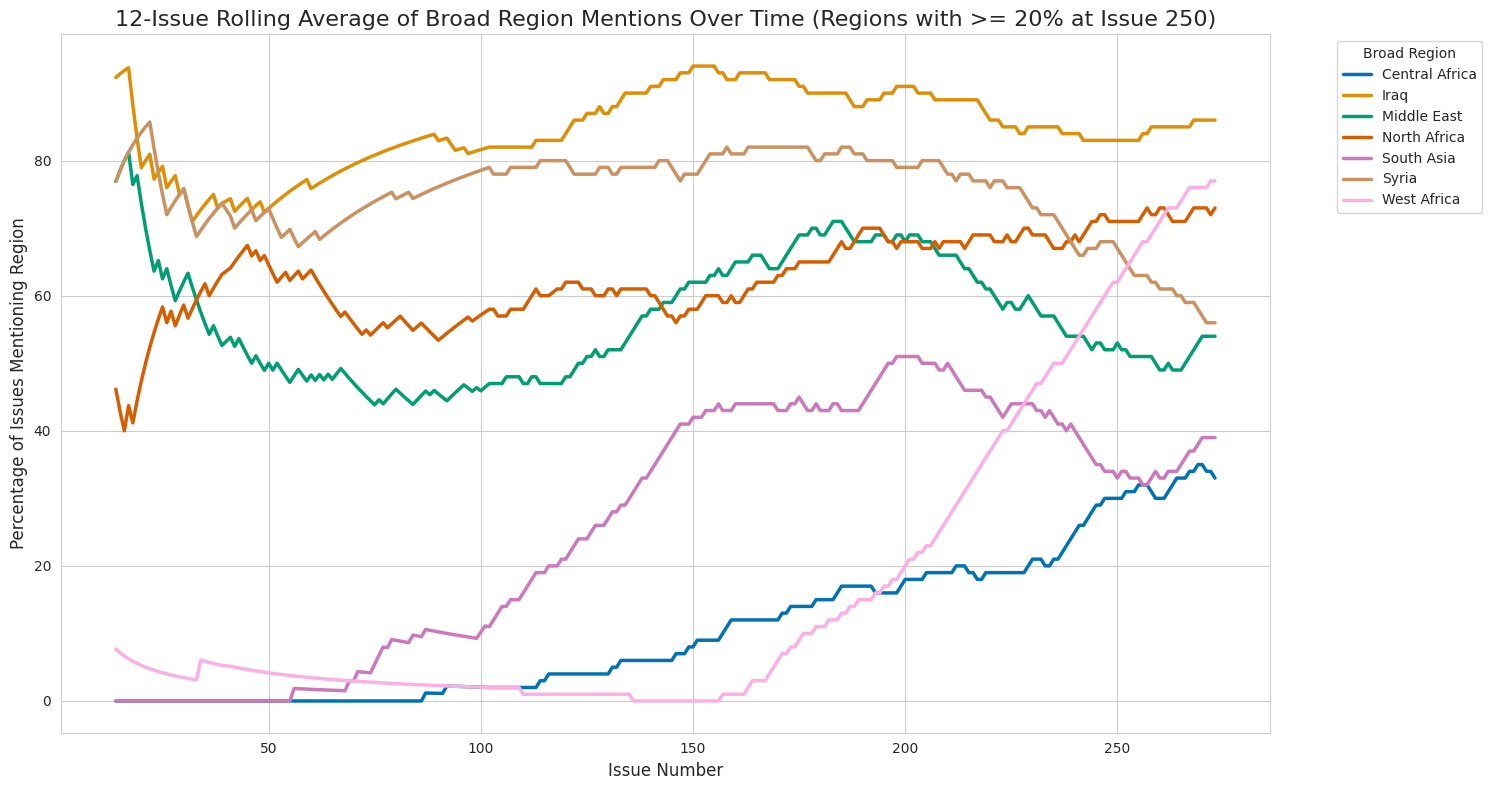

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transpose the DataFrame for plotting (issues as index, regions as columns)
broad_region_rolling_average_percentage_T = broad_region_rolling_average_percentage.T

# Identify broad regions with rolling average percentage below 20% at issue 250
regions_to_hide = broad_region_rolling_average_percentage_T.loc[250] < 20
regions_to_plot = broad_region_rolling_average_percentage_T.columns[~regions_to_hide]

# Filter the DataFrame to include only the regions to plot
filtered_broad_region_rolling_average_percentage_T = broad_region_rolling_average_percentage_T[regions_to_plot]

# Hide results for the first 12 issues by slicing the DataFrame starting from index 12 (Issue number 13)
filtered_broad_region_rolling_average_percentage_T = filtered_broad_region_rolling_average_percentage_T.iloc[12:]


# Set the style for the plot
sns.set_style("whitegrid")

# Set a colorblind-friendly palette
sns.set_palette("colorblind")

# Create the line plot
plt.figure(figsize=(15, 8)) # Adjust figure size as needed

# Plot each column (broad region) as a line with bolder lines
for column in filtered_broad_region_rolling_average_percentage_T.columns:
    sns.lineplot(data=filtered_broad_region_rolling_average_percentage_T, x=filtered_broad_region_rolling_average_percentage_T.index, y=column, label=column, linewidth=2.5) # Increased linewidth

# Add title and labels
plt.title('12-Issue Rolling Average of Broad Region Mentions Over Time (Regions with >= 20% at Issue 250)', fontsize=16)
plt.xlabel('Issue Number', fontsize=12)
plt.ylabel('Percentage of Issues Mentioning Region', fontsize=12)

# Improve legend placement
plt.legend(title='Broad Region', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Show the plot
plt.show()

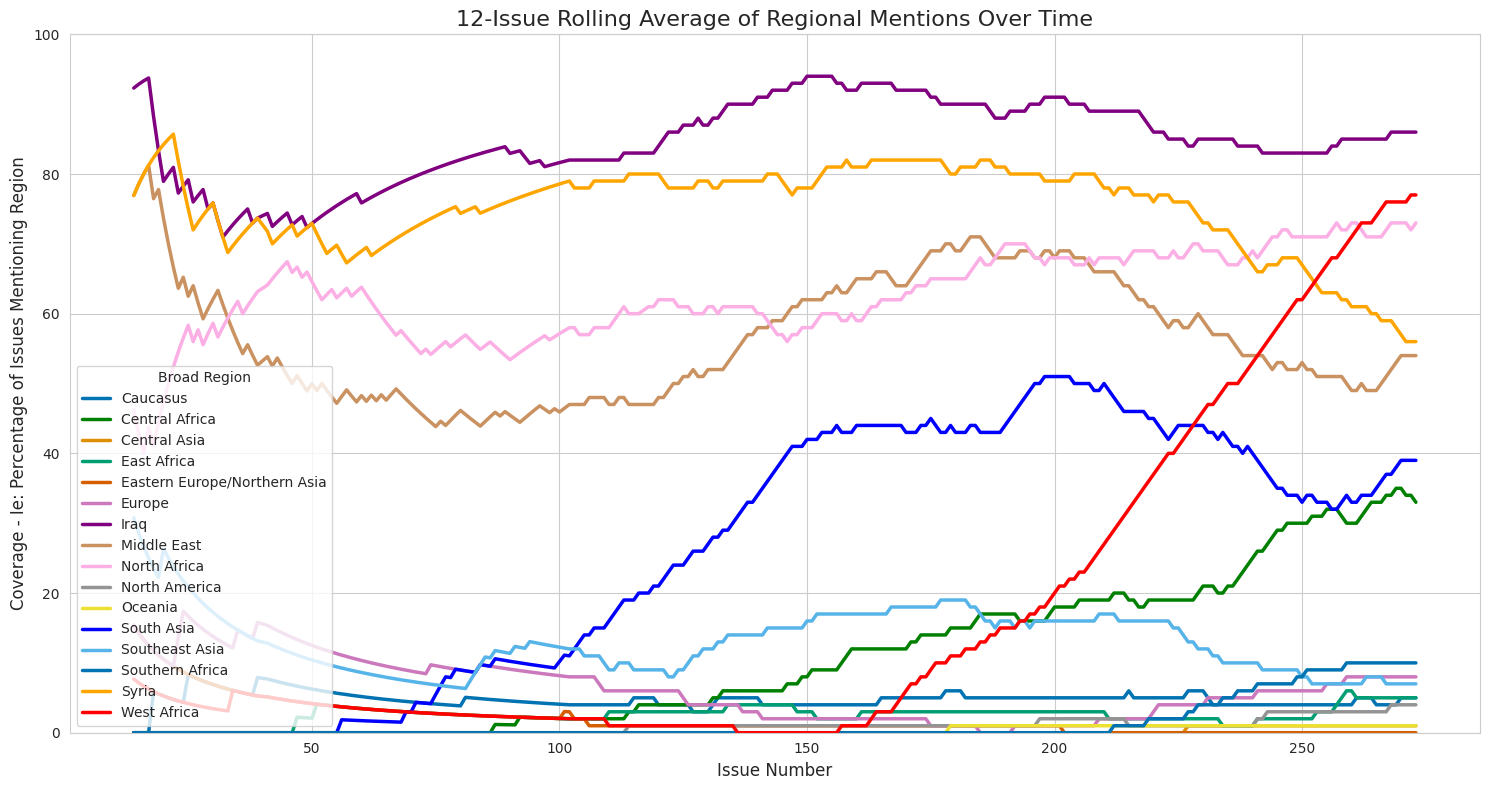

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transpose the DataFrame for plotting (issues as index, regions as columns)
broad_region_rolling_average_percentage_T = broad_region_rolling_average_percentage.T

# Identify broad regions to hide based on user request
regions_to_hide_explicit = ['Middle East', 'North Africa']

# Identify broad regions with rolling average percentage below 20% at issue 250
regions_to_hide_low_percentage = broad_region_rolling_average_percentage_T.loc[250] < 20

# Combine both criteria for hiding regions
regions_to_hide = regions_to_hide_explicit + list(broad_region_rolling_average_percentage_T.columns[regions_to_hide_low_percentage])
regions_to_plot = [col for col in broad_region_rolling_average_percentage_T.columns if col not in regions_to_hide]


# Filter the DataFrame to include only the regions to plot
filtered_broad_region_rolling_average_percentage_T = broad_region_rolling_average_percentage_T.iloc[12:]


# Set the style for the plot
sns.set_style("whitegrid")

# Define custom colors
custom_colors = {
    'Iraq': 'purple',
    'Syria': 'orange',
    'Central Africa': 'green',
    'South Asia': 'blue',
    'West Africa': 'red' # Changed West Africa to red as requested
}

# Create the line plot
plt.figure(figsize=(15, 8)) # Adjust figure size as needed

# Plot each column (broad region) as a line with custom colors and bolder lines
for column in filtered_broad_region_rolling_average_percentage_T.columns:
    # Get the color from custom_colors if the region is in the dictionary, otherwise use default
    color = custom_colors.get(column, None) # Use None to let seaborn choose default if not in custom_colors
    sns.lineplot(data=filtered_broad_region_rolling_average_percentage_T, x=filtered_broad_region_rolling_average_percentage_T.index, y=column, label=column, linewidth=2.5, color=color) # Increased linewidth and added color

# Set y-axis limits from 0 to 100
plt.ylim(0, 100)

# Add title and labels
plt.title('12-Issue Rolling Average of Regional Mentions Over Time', fontsize=16)
plt.xlabel('Issue Number', fontsize=12)
plt.ylabel('Coverage - Ie: Percentage of Issues Mentioning Region', fontsize=12) # Updated label

# Improve legend placement
plt.legend(title='Broad Region', bbox_to_anchor=(0, 0), loc='lower left')

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Show the plot
plt.show()

#### Final simplified version:

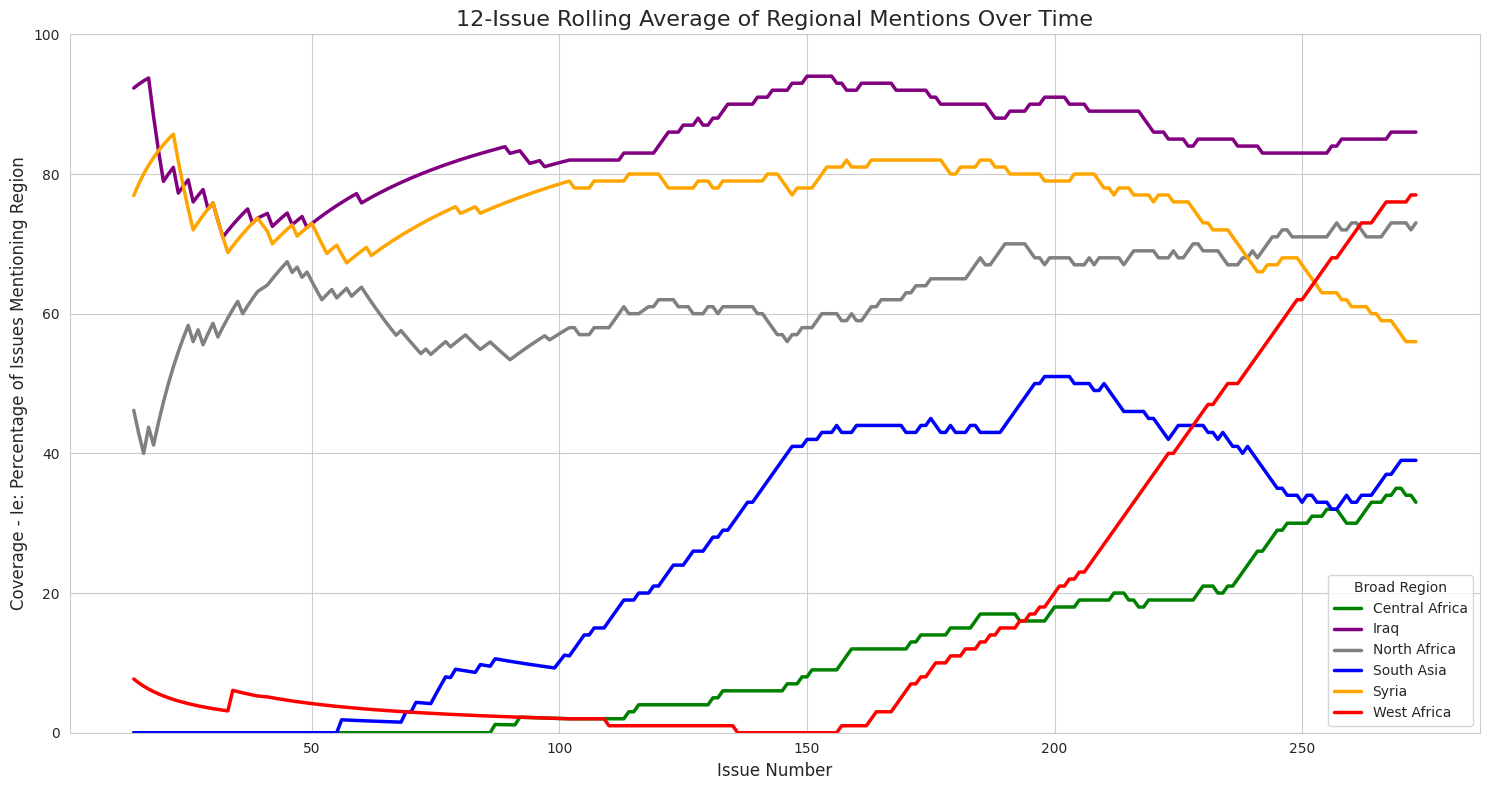

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transpose the DataFrame for plotting (issues as index, regions as columns)
broad_region_rolling_average_percentage_T = broad_region_rolling_average_percentage.T

# Identify broad regions to hide based on user request
regions_to_hide_explicit = ['Middle East']

# Identify broad regions with rolling average percentage below 20% at issue 250
regions_to_hide_low_percentage = broad_region_rolling_average_percentage_T.loc[250] < 20

# Combine both criteria for hiding regions
regions_to_hide = regions_to_hide_explicit + list(broad_region_rolling_average_percentage_T.columns[regions_to_hide_low_percentage])
regions_to_plot = [col for col in broad_region_rolling_average_percentage_T.columns if col not in regions_to_hide]


# Filter the DataFrame to include only the regions to plot
filtered_broad_region_rolling_average_percentage_T = broad_region_rolling_average_percentage_T[regions_to_plot]

# Hide results for the first 12 issues by slicing the DataFrame starting from index 12 (Issue number 13)
filtered_broad_region_rolling_average_percentage_T = filtered_broad_region_rolling_average_percentage_T.iloc[12:]


# Set the style for the plot
sns.set_style("whitegrid")

# Define custom colors
custom_colors = {
    'Iraq': 'purple',
    'Syria': 'orange',
    'Central Africa': 'green',
    'North Africa' : 'gray',
    'South Asia': 'blue',
    'West Africa': 'red' # Changed West Africa to red as requested
}

# Create the line plot
plt.figure(figsize=(15, 8)) # Adjust figure size as needed

# Plot each column (broad region) as a line with custom colors and bolder lines
for column in filtered_broad_region_rolling_average_percentage_T.columns:
    # Get the color from custom_colors if the region is in the dictionary, otherwise use default
    color = custom_colors.get(column, None) # Use None to let seaborn choose default if not in custom_colors
    sns.lineplot(data=filtered_broad_region_rolling_average_percentage_T, x=filtered_broad_region_rolling_average_percentage_T.index, y=column, label=column, linewidth=2.5, color=color) # Increased linewidth and added color

# Set y-axis limits from 0 to 100
plt.ylim(0, 100)

# Add title and labels
plt.title('12-Issue Rolling Average of Regional Mentions Over Time', fontsize=16)
plt.xlabel('Issue Number', fontsize=12)
plt.ylabel('Coverage - Ie: Percentage of Issues Mentioning Region', fontsize=12) # Updated label

# Improve legend placement
plt.legend(title='Broad Region', bbox_to_anchor=(1, 0), loc='lower right')

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Show the plot
plt.show()

#### Prep work at Country custom level:

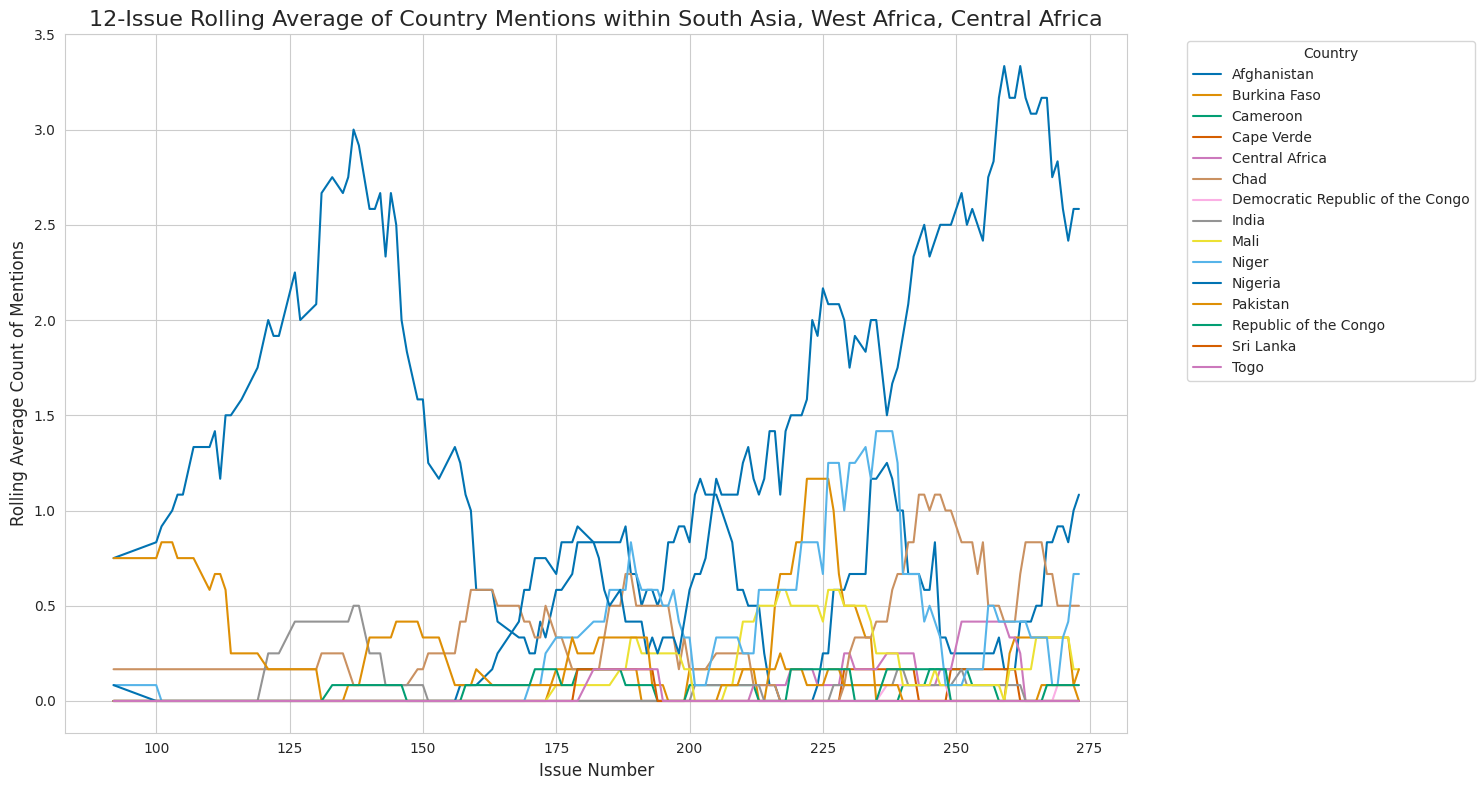

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the broad regions to break down by country
regions_to_breakdown = ['South Asia', 'West Africa', 'Central Africa']

# Filter country_counts_graph to include only countries in the specified broad regions
# Need to ensure 'Country' column in country_counts_graph is clean and matches keys in country_to_broad_region
country_counts_graph['Broad_Region'] = country_counts_graph['Country'].apply(
    lambda x: country_to_broad_region.get(x.strip(), None) if isinstance(x, str) else None
)

filtered_country_counts = country_counts_graph[country_counts_graph['Broad_Region'].isin(regions_to_breakdown)].copy()

# Create a pivot table with Issue number as index, Country as columns, and Count as values
country_issue_pivot = filtered_country_counts.pivot_table(
    index='Issue number',
    columns='Country',
    values='Count',
    fill_value=0
)

# Calculate the 12-issue rolling average for countries
country_rolling_average = country_issue_pivot.rolling(window=12, min_periods=1).mean()

# Convert to percentage (optional, but consistent with broad region chart)
# For country level, the raw count rolling average might be more informative
# Let's stick to raw counts for now unless percentage is explicitly requested

# Hide results for the first 12 issues
country_rolling_average = country_rolling_average.iloc[11:] # .iloc[11] corresponds to the 12th issue (index 11)


# Set the style for the plot
sns.set_style("whitegrid")

# Create the line plot for each country within the specified regions
plt.figure(figsize=(15, 8)) # Adjust figure size as needed

# Plot each column (country) as a line
for column in country_rolling_average.columns:
    sns.lineplot(data=country_rolling_average, x=country_rolling_average.index, y=column, label=column)

# Add title and labels
plt.title('12-Issue Rolling Average of Country Mentions within South Asia, West Africa, Central Africa', fontsize=16)
plt.xlabel('Issue Number', fontsize=12)
plt.ylabel('Rolling Average Count of Mentions', fontsize=12)

# Improve legend placement
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Show the plot
plt.show()

#### Define the map to the custom country groups:

In [ ]:
# Define a dictionary to map countries to broader regional groups
country_to_broad_region2 = {
    'Iraq': 'Iraq',
    'Syria': 'Syria',
    'Iran': 'Middle East',
    'Lebanon': 'Middle East',
    'Jordan': 'Middle East',
    'Egypt': 'Egypt',
    'Saudi Arabia': 'Middle East',
    'Palestine': 'Palestine',
    'Kuwait': 'Middle East',
    'Yemen': 'Yemen',
    'United Arab Emirates': 'Middle East',
    'Tunisia': 'North Africa',
    'Morocco': 'North Africa',
    'Algeria': 'North Africa',
    'Libya': 'Libya',
    'Sudan': 'North Africa',
    'Somalia': 'East Africa',
    'Ethiopia': 'East Africa',
    'Kenya': 'East Africa',
    'Djibouti': 'East Africa',
    'Eritrea': 'East Africa',
    'Tanzania': 'East Africa',
    'Indonesia': 'Southeast Asia',
    'Malaysia': 'Southeast Asia',
    'Philippines': 'Southeast Asia',
    'Pakistan': 'South Asia',
    'India': 'South Asia',
    'Sri Lanka': 'South Asia',
    'Afghanistan': 'Afghanistan',
    'Nigeria': 'Nigeria',
    'Niger': 'Niger+Mali+Burkina Faso',
    'Mali': 'Niger+Mali+Burkina Faso',
    'Burkina Faso': 'Niger+Mali+Burkina Faso',
    'Ghana': 'West Africa',
    'Mauritania': 'West Africa',
    'Togo': 'West Africa',
    'Chad': 'Chad+Cameroon',
    'Cameroon': 'Chad+Cameroon',
    'Democratic Republic of the Congo': 'Central Africa',
    'Republic of the Congo': 'Central Africa',
    'Central Africa': 'Central Africa',
    'Europe': 'Europe',
    'France': 'Europe',
    'Belgium': 'Europe',
    'Sweden': 'Europe',
    'Austria': 'Europe',
    'Georgia': 'Caucasus',
    'Azerbaijan': 'Caucasus',
    'Armenia': 'Caucasus',
    'Turkmenistan': 'Central Asia', # Assuming Turkmenistan is considered Central Asia in this context
    'Mozambique': 'Southern Africa', # Assuming Mozambique is considered Southern Africa
    'Cape Verde': 'West Africa', # Assuming Cape Verde is considered West Africa
    'Russia': 'Eastern Europe/Northern Asia', # Russia spans multiple regions
    'United Kingdom': 'Europe',
    'US': 'North America', # Assuming 'US' refers to United States
    'Australia': 'Oceania'
}

In [ ]:
import ast # Import the ast module

# Function to map a list of countries to a list of unique broad regions
def map_countries_to_broad_regions(country_list_str, country_to_broad_region_map2):
    if not isinstance(country_list_str, str):
        return None

    try:
        # Safely evaluate the string representation of the list
        country_list = ast.literal_eval(country_list_str)
        if not isinstance(country_list, list):
            return None # Return None if evaluation doesn't result in a list
    except (ValueError, SyntaxError):
        print(f"Could not evaluate string as list: {country_list_str}")
        return None # Return None if string cannot be evaluated as a list


    regions = set()
    for country in country_list:
        # Clean up country names by stripping whitespace and converting to lowercase
        cleaned_country = country.strip() if isinstance(country, str) else None
        if cleaned_country: # Check if cleaned_country is not None or empty
            # Attempt to match cleaned country directly
            if cleaned_country in country_to_broad_region_map2:
                regions.add(country_to_broad_region_map2[cleaned_country])
            else:
                # Optional: Print countries not found in the mapping for debugging
                print(f"Warning: No broad region mapping for country: '{cleaned_country}'")


    return list(regions) if regions else None

# Apply the function to the 'Countries_Mentioned' column
unique_country_mentions_per_issue['Broad_Regions_Mentioned'] = unique_country_mentions_per_issue['Countries_Mentioned'].apply(
    lambda x: map_countries_to_broad_regions(x, country_to_broad_region2)
)

# Count the number of unique broad regions mentioned per issue
unique_country_mentions_per_issue['Unique_Broad_Region_Count'] = unique_country_mentions_per_issue['Broad_Regions_Mentioned'].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Display the updated DataFrame
display(unique_country_mentions_per_issue.head())

Issue number  Unique_Country_Count  \
0             1                     8   
1             2                     4   
2             3                     5   
3             4                     3   
4             5                     2   

                                 Countries_Mentioned  \
0  ['Iraq', 'Morocco', 'USA', 'Russia', 'Iran', '...   
1            ['Iraq', 'Tunisia', 'Morocco', 'Syria']   
2   ['Iraq', 'Malaysia', 'Iran', 'Syria', 'Morocco']   
3                        ['Russia', 'Iraq', 'Syria']   
4                                ['Lebanon', 'Iraq']   

                             Broad_Regions_Mentioned  \
0  [Eastern Europe/Northern Asia, Egypt, Middle E...   
1                        [North Africa, Iraq, Syria]   
2  [Middle East, Southeast Asia, Syria, North Afr...   
3        [Eastern Europe/Northern Asia, Iraq, Syria]   
4                                [Iraq, Middle East]   

   Unique_Broad_Region_Count  
0                          6  
1                          3  
2                          5  
3                          3  
4                          2

In [ ]:
all_broad_regions = set()
for regions_list in unique_country_mentions_per_issue['Broad_Regions_Mentioned'].dropna():
    all_broad_regions.update(regions_list)
all_broad_regions = sorted(list(all_broad_regions))

# Create a list of all unique issue numbers
all_issue_numbers = sorted(unique_country_mentions_per_issue['Issue number'].unique())

# Create an empty DataFrame with broad regions as index and issue numbers as columns, initialized with 0s
broad_region_issue_table = pd.DataFrame(0, index=all_broad_regions, columns=all_issue_numbers)

# Populate the table: mark 1 if a broad region was mentioned in an issue
for index, row in unique_country_mentions_per_issue.iterrows():
    issue_number = row['Issue number']
    regions_mentioned = row['Broad_Regions_Mentioned']
    if isinstance(regions_mentioned, list):
        for region in regions_mentioned:
            if region in broad_region_issue_table.index:
                broad_region_issue_table.loc[region, issue_number] = 1


#### Results of individual mention of custom country groupings by issue

In [ ]:
display(broad_region_issue_table.head(25))

1    2    3    4    5    6    7    8    9    \
Afghanistan                     0    0    0    0    0    0    0    0    0   
Caucasus                        0    0    0    0    0    0    0    0    0   
Central Africa                  0    0    0    0    0    0    0    0    0   
Central Asia                    0    0    0    0    0    0    0    0    0   
Chad+Cameroon                   0    0    0    0    0    0    0    0    0   
East Africa                     0    0    0    0    0    0    0    0    0   
Eastern Europe/Northern Asia    1    0    0    1    0    0    0    0    0   
Egypt                           1    0    0    0    0    0    0    0    0   
Europe                          0    0    0    0    0    1    1    0    0   
Iraq                            1    1    1    1    1    1    1    1    1   
Libya                           0    0    0    0    0    0    0    0    0   
Middle East                     1    0    1    0    1    0    1    1    0   
Niger+Mali+Burkina Faso         0    0    0    0    0    0    0    0    0   
Nigeria                         0    0    0    0    0    0    0    1    0   
North Africa                    1    1    1    0    0    0    1    1    0   
North America                   0    0    0    0    0    0    0    0    0   
Oceania                         0    0    0    0    0    0    0    0    0   
Palestine                       0    0    0    0    0    0    0    0    0   
South Asia                      0    0    0    0    0    0    0    0    0   
Southeast Asia                  0    0    1    0    0    0    1    1    0   
Southern Africa                 0    0    0    0    0    0    0    0    0   
Syria                           1    1    1    1    0    1    1    1    1   
West Africa                     0    0    0    0    0    0    0    0    0   
Yemen                           0    0    0    0    0    1    0    0    1   

                              11   ...  264  265  266  267  268  269  270  \
Afghanistan                     0  ...    0    1    0    1    0    1    1   
Caucasus                        0  ...    0    0    0    0    0    0    1   
Central Africa                  0  ...    0    0    0    1    0    1    0   
Central Asia                    0  ...    0    0    0    0    0    0    0   
Chad+Cameroon                   0  ...    1    0    0    0    0    0    0   
East Africa                     0  ...    0    0    0    0    0    0    0   
Eastern Europe/Northern Asia    0  ...    0    0    0    0    0    0    0   
Egypt                           0  ...    0    0    0    1    0    1    1   
Europe                          0  ...    0    0    0    0    0    0    0   
Iraq                            1  ...    1    1    1    1    1    1    1   
Libya                           0  ...    0    0    0    0    0    0    0   
Middle East                     0  ...    0    1    1    1    1    1    1   
Niger+Mali+Burkina Faso         0  ...    0    1    0    0    1    0    1   
Nigeria                         0  ...    1    1    1    1    0    1    1   
North Africa                    0  ...    0    1    0    0    1    0    1   
North America                   0  ...    0    0    0    0    1    0    0   
Oceania                         0  ...    0    0    0    0    0    0    0   
Palestine                       0  ...    1    0    0    0    0    1    1   
South Asia                      0  ...    0    0    1    0    0    0    0   
Southeast Asia                  0  ...    0    0    0    0    0    0    0   
Southern Africa                 0  ...    0    0    0    0    0    0    0   
Syria                           0  ...    0    1    0    1    1    0    0   
West Africa                     0  ...    0    0    0    0    0    0    0   
Yemen                           0  ...    0    0    0    0    0    0    0   

                              271  272  273  
Afghanistan                     0    1    1  
Caucasus                        0    0    0  
Central Africa                  0    0  

In [ ]:
# Calculate the 12-issue rolling average
# The axis=1 argument applies the rolling window across the columns (issues)
# The .T transposes the DataFrame so rolling is applied to columns (regions) over the index (issues)
# Then transpose back to have regions as index and rolling average over issues as columns
broad_region_rolling_average = broad_region_issue_table.T.rolling(window=100, min_periods=1).mean().T

# Convert to percentage
broad_region_rolling_average_percentage = broad_region_rolling_average * 100

# Display the resulting rolling average table as percentages
print("12-Issue Rolling Average of Broad Region Mentions (Percentage):")
# Using .style.format to display as percentages with no decimal places
display(broad_region_rolling_average_percentage.style.format("{:.0f}%"))

12-Issue Rolling Average of Broad Region Mentions (Percentage):


#### Graphical representation of custom countries:

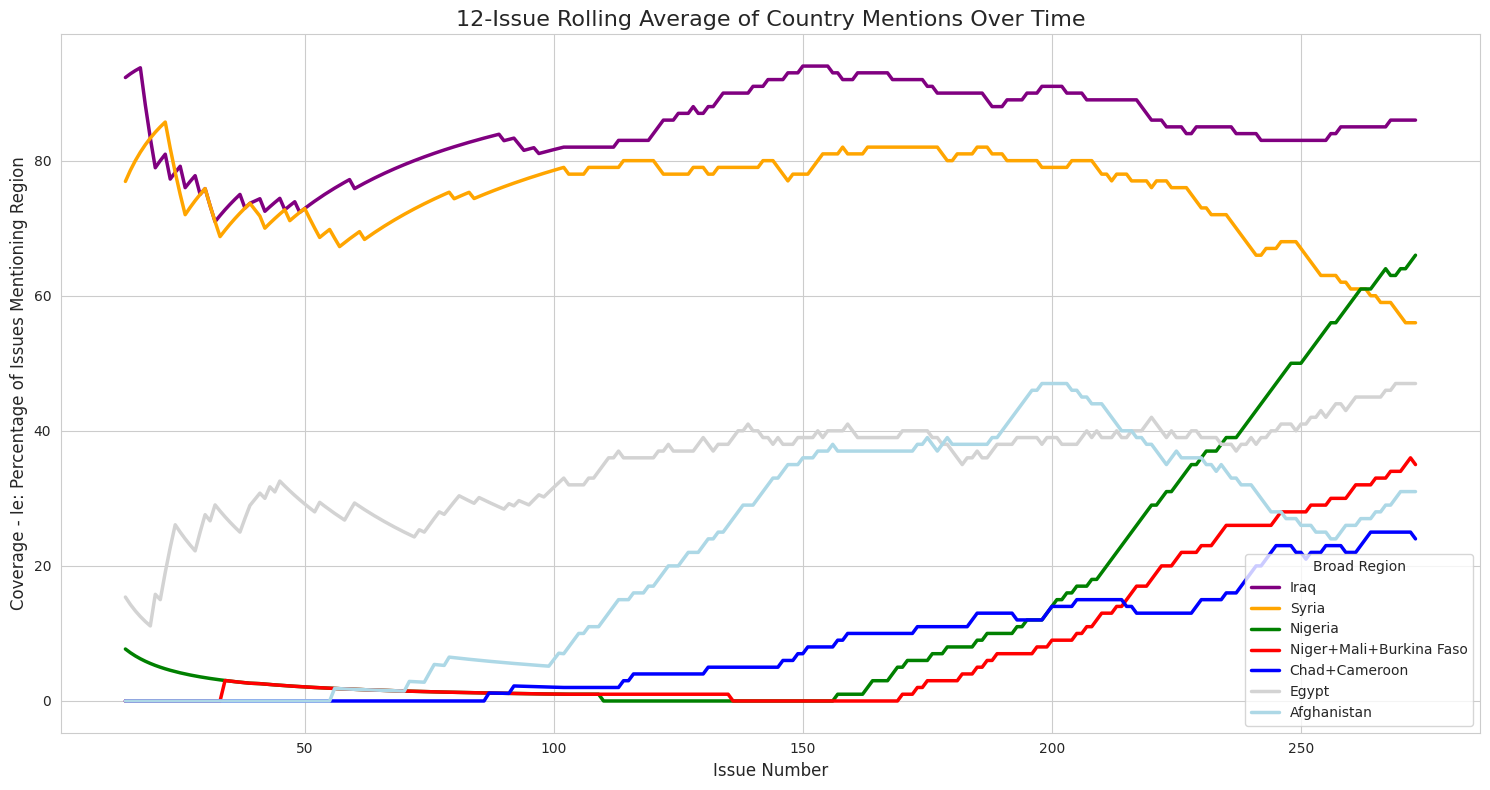

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transpose the DataFrame for plotting (issues as index, regions as columns)
broad_region_rolling_average_percentage_T = broad_region_rolling_average_percentage.T

# Define custom colors
custom_colors2 = {
    'Iraq': 'purple',
    'Syria': 'orange',
    'Nigeria': 'green',
    'Niger+Mali+Burkina Faso': 'red',
    'Chad+Cameroon': 'blue',
    'Egypt': 'lightgray',
    'Afghanistan': 'lightblue' # Changed Afghanistan color to lightgray
}

# Identify broad regions to plot - only include regions that are keys in custom_colors2
regions_to_plot = [region for region in custom_colors2.keys() if region in broad_region_rolling_average_percentage_T.columns]

# Filter the DataFrame to include only the regions to plot
filtered_broad_region_rolling_average_percentage_T = broad_region_rolling_average_percentage_T[regions_to_plot]

# Hide results for the first 12 issues by slicing the DataFrame starting from index 12 (Issue number 13)
filtered_broad_region_rolling_average_percentage_T = filtered_broad_region_rolling_average_percentage_T.iloc[12:]


# Set the style for the plot
sns.set_style("whitegrid")

# Set a colorblind-friendly palette
# sns.set_palette("colorblind") # Removed to avoid overriding custom colors for specified regions

# Create the line plot
plt.figure(figsize=(15, 8)) # Adjust figure size as needed

# Plot each column (broad region) as a line with bolder lines and custom colors
for column in filtered_broad_region_rolling_average_percentage_T.columns:
    # Get the color from custom_colors2 if the region is in the dictionary
    color = custom_colors2.get(column)
    if color: # If a custom color is found, use it
        sns.lineplot(data=filtered_broad_region_rolling_average_percentage_T, x=filtered_broad_region_rolling_average_percentage_T.index, y=column, label=column, linewidth=2.5, color=color)
    else: # Otherwise, let seaborn choose from the default palette (or set a different palette here)
        sns.lineplot(data=filtered_broad_region_rolling_average_percentage_T, x=filtered_broad_region_rolling_average_percentage_T.index, y=column, label=column, linewidth=2.5)


# Add title and labels
plt.title('12-Issue Rolling Average of Country Mentions Over Time', fontsize=16)
plt.xlabel('Issue Number', fontsize=12)
plt.ylabel('Coverage - Ie: Percentage of Issues Mentioning Region', fontsize=12) # Updated label

# Improve legend placement
plt.legend(title='Broad Region', bbox_to_anchor=(1, 0), loc='lower right')

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# Show the plot
plt.show()



---



# **Export**

### *Sheet Definition & Export*

In [ ]:
spreadsheet_name = 'My Exported City Data v1'
sh = gc.create(spreadsheet_name)

### Export to GSheets

In [ ]:
import datetime
import pandas as pd # Import pandas

matched_locations_df_copy = matched_locations_df.copy()

# Reset the index to make 'city' a column
matched_locations_df_copy = matched_locations_df_copy.reset_index()

# Convert all columns to string type to handle potential NaN and list issues for gspread
matched_locations_df_copy = matched_locations_df_copy.astype(str)

# Convert the DataFrame to a list of lists for gspread
data_to_export = [matched_locations_df_copy.columns.values.tolist()] + matched_locations_df_copy.values.tolist()

# Generate a unique worksheet title using a timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
worksheet_title = f'DataFrame_Export_{timestamp}'

# Check if a worksheet with the same title already exists and delete it if it does
try:
    worksheet = sh.worksheet(worksheet_title)
    sh.del_worksheet(worksheet)
    print(f"Deleted existing worksheet: {worksheet_title}")
except gspread.WorksheetNotFound:
    pass # Worksheet doesn't exist, no need to delete

worksheet = sh.add_worksheet(title=worksheet_title, rows=len(data_to_export), cols=len(matched_locations_df_copy.columns))
worksheet.update(data_to_export)

print(f"Successfully exported data to Google Sheet '{spreadsheet_name}' in worksheet '{worksheet_title}'.")

Successfully exported data to Google Sheet 'My Exported City Data v1' in worksheet 'DataFrame_Export_20251007_131825'.


In [ ]:
spreadsheet_name = 'My Exported Data v2-1'
sh = gc.create(spreadsheet_name)



---

